In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr

In [2]:
az.style.use('arviz-doc')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/Logo_UNSAM.png" width="200"></center>
<br>
<br>
<h1 align="center">Modelos de mezcla</h1>    


<br>
<br>
<br>
<br>
<br>

## Objetivos

<br>

Introducción a:

* Modelos de mezclas finitos
* Mezcla de Gaussianas
* No-identificabilidad
* Modelos zero-inflados y modelos hurdle
* Modelos de mezcla infinitos (procesos de Dirichlet)
* Modelos de mezcla continuos

## Modelos de mezcla

<br>
<br>


* Un modelo de mezcla se construyen combinando distribuciones más simples para obtener otras más complejas 


<br>
<br>

## Modelos de mezclas finitas


Podemos constuir una distribución $p(x)$ general, como una combinación ponderada de $K$ distribuciones base $p(x \mid \theta_i)$, parametrizadas por $\theta_i$.


$$
p(x) = \sum_{i=1}^{K} w_i p(x \mid \theta_i)
$$

Donde:

* $w_i$ son los **pesos** de la mezcla. Estos pesos deben cumplir $w_i \geq 0$ y $\sum_{i=1}^{K} w_i = 1$

## Mezclas finitas de Gaussianas

<br>

* Si $K$ es finito y $p(x \mid \theta_i)$ es una gaussiana, entonces $p(x)$ es una mezcla finita de Gaussiana.

* Por ej, la curva azul en la siguiente figura es una mezcla de 7 Gaussianas


<center><img src="../img/KDE_example.png" width=700 /></center>

## Mezclas finitas de Gaussianas

<br>
<br>


* Dado un número suficiente de gaussianas y ajustando sus medias y (co)varianzas, así como los pesos $w$ es posible aproxima _casi_
cualquier densidad continua con precisión arbitraria.


* Y que sucede con distribuciones discretas?

<br>

## Kernel density estimate

* KDE es un método no paramétrico para estimar la función de densidad de probabilidad de una variable aleatoria a partir de muestras.
* Kernel es el nombre que se le da a la distribución base
* Un kernel muy usado es el Gaussiano
* En principio es un KDE se ubica una Gaussiana sobre cada observación
* Por eso se llama no-paramétrico, que en realidad quiere decir que la cantidad de parámetros crece con los datos
* En la práctica hay muchas optimizaciones y detalles de implementación que no discutiremos


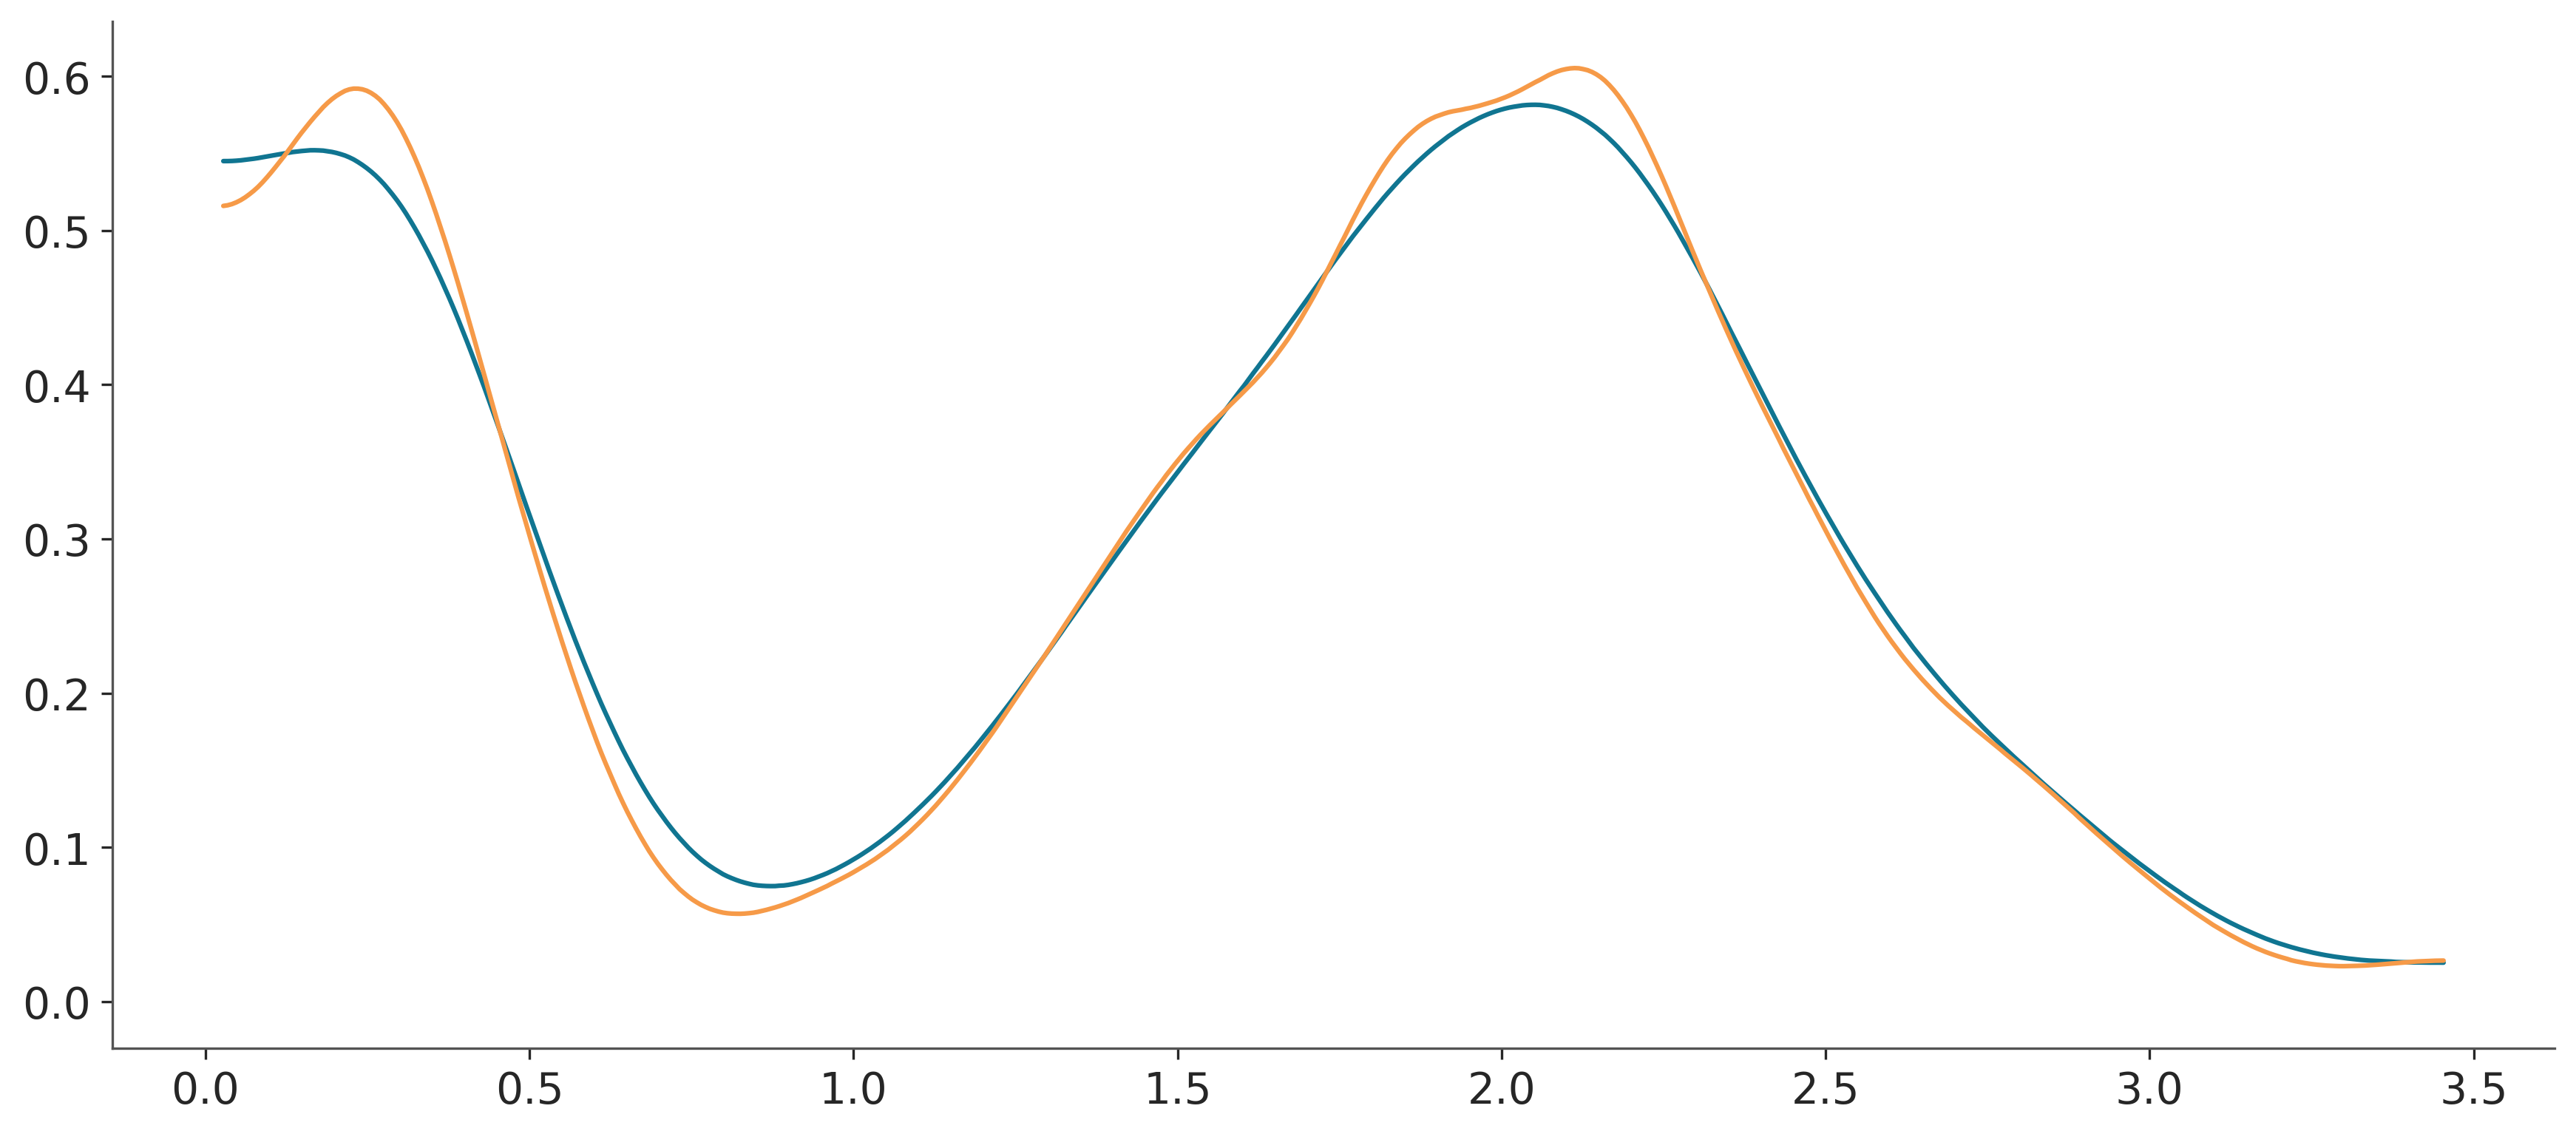

In [5]:
sample = np.concatenate([pz.Beta(2, 5).rvs(200, random_state=42), 
                         pz.Normal(2, 0.5).rvs(500, random_state=42)])
az.plot_kde(sample, plot_kwargs={"color":"C0"});
az.plot_kde(sample, bw="isj", plot_kwargs={"color":"C2"});

## Cómo resolver un modelo de mezclas

<br>
<br>

* Dado un conjunto de datos, debemos asignar a cada dato uno de los componentes.
* En un modelo probabilista podemos hacer esto introduciendo una variable $z$
* $z$ suele recibir el nombre de `variable latente`, ya que no es una variable que pueda ser observada.

<br>
<br>

## Cómo resolver un modelo de mezclas II

<br>

Si nuestros componentes son Gaussianos entonces tendremos que:
<br>
<br>

\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K & \sim N(0, \sigma^2) \\
x & \sim N(\mu_z, \sigma^2)
\end{align*}
\end{split}


Es decir:
* usamos $z$ para indexar $K$ Gaussianas.
* y $z$ tendrá la misma dimensión que $x$ y podrá tomar tantos valores como $K$ Gaussianas tengamos.

## Cómo resolver un modelo de mezclas III

Una forma *natural* de completar el modelos Bayesiano es:
* Establer a $z$ como una distribución categórica con parámetro $p$ y soporte $\{0, \dots ,K-1\}$
* Establecer que $p$ sigue una distribución de Dirichlet
* Para la desviación standard de la gaussiana usamos una media-normal o similar, entonces nos queda:



\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K & \sim N(0, \sigma^2) \\
\sigma & \sim \mathcal{HN}(\dots) \\
\boldsymbol{w} & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
z & \sim \textrm{Cat}(\boldsymbol{w}) \\
x & \sim N(\mu_z, \sigma^2)
\end{align*}
\end{split}

## La distribución categórica

* Es una distribución discreta, también conocida como Bernoulli generalizada o multinoulli
* Describe los posibles resultados de una variable aleatoria que puede tomar $K$ categorías
* La categoría de cada probabilidad se especifica por separado
* No hay orden intrínseco de la categorías, si se le asocian números es por conveniencia.
* La distribución categórica de dimensión $K$ es la distribución más general para representr $K$-eventos.

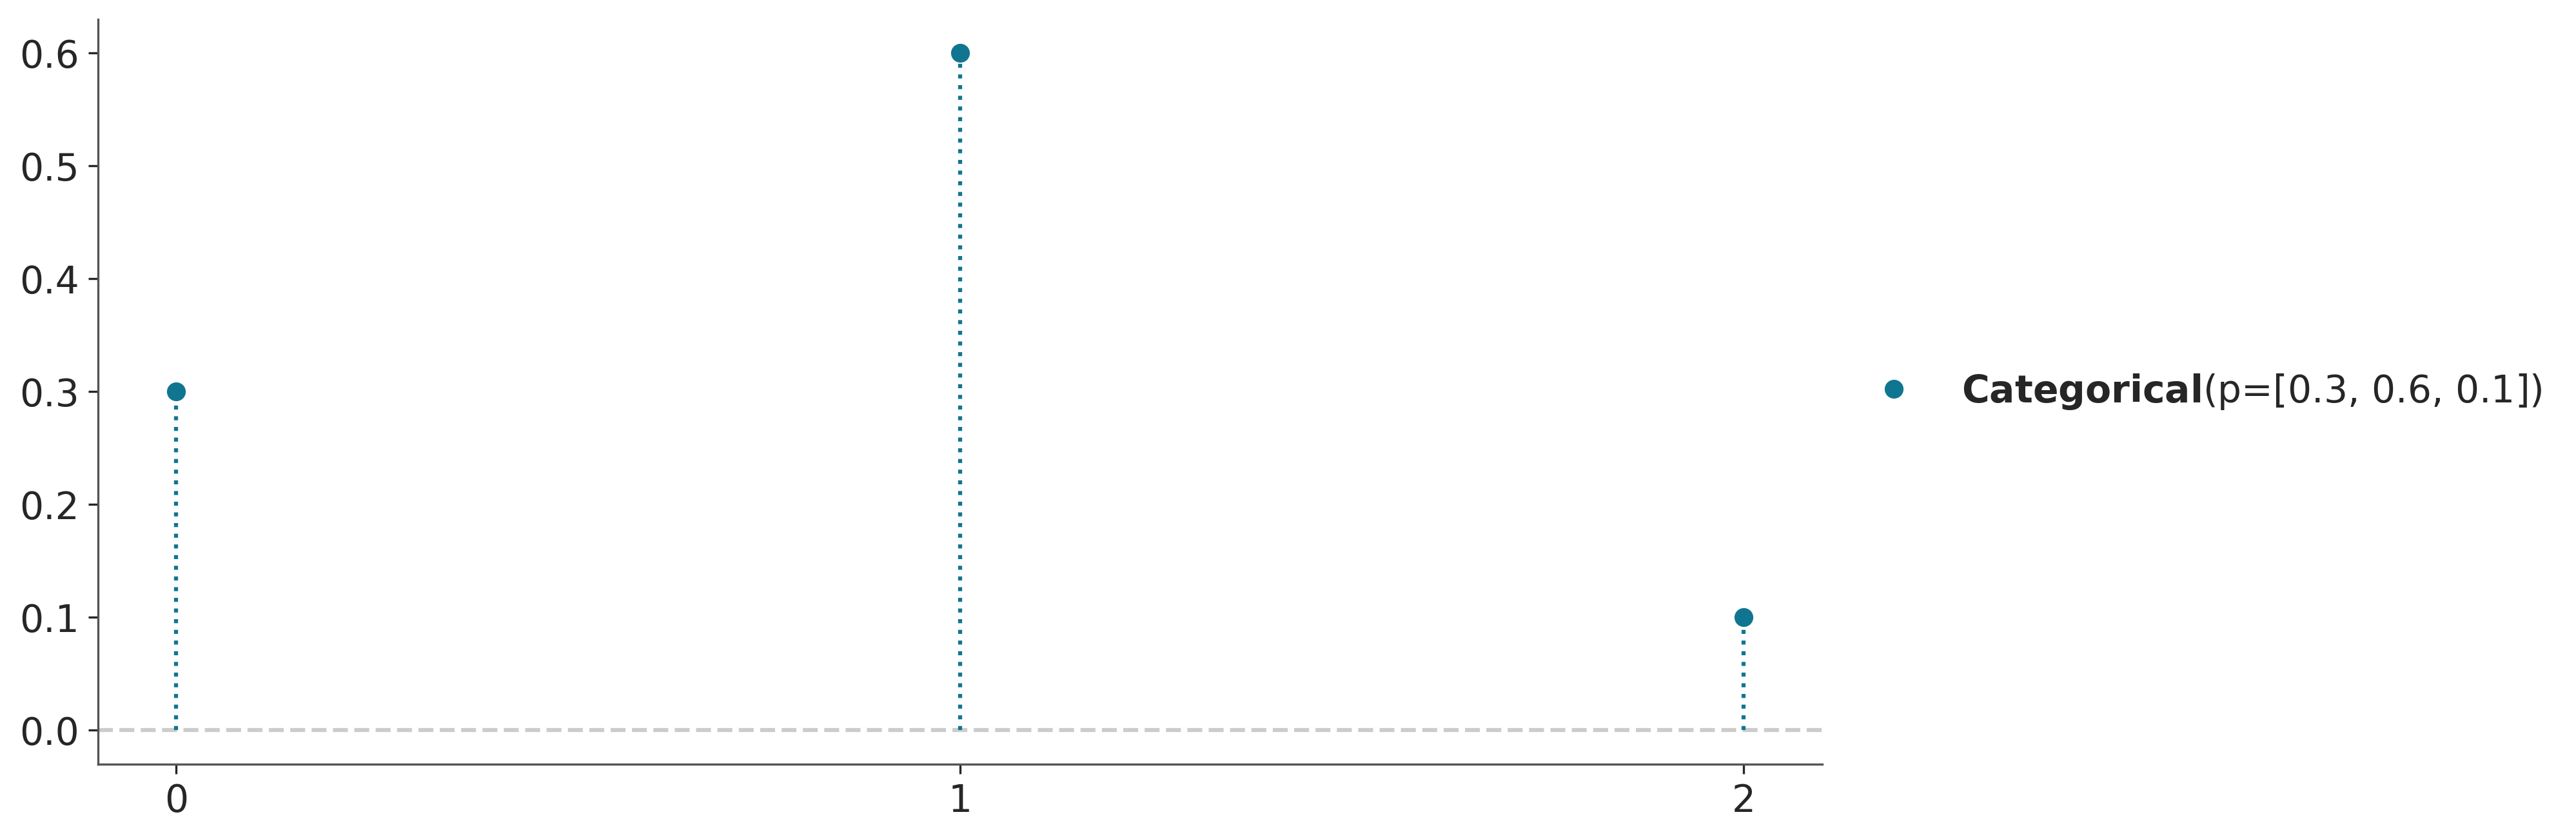

In [6]:
pz.Categorical([0.3, 0.6, 0.1]).plot_pdf();

## Distribución de Dirichlet

* Es una distribución continua multivariada
* Es la generaización de la Beta 
* Se parametriza por un vector $\alpha$ cuyos valores son reales positivos.
* Describe un vector de probabilidades.
* Geométricamente podemos pensar como una distribución sobre el simplex

### Simplex

* Un símplex es una generalización de la noción de triángulo a dimensiones arbitrarias. 
* Si tengo un vector cuyos elementos $w_i \geq 0$ y $\sum_{i=1}^{K} w_i = 1$ entonces el espacio de soluciones es un simplex

Para un vector de 3 elementos:
    
<center><img src="img/2D-simplex.svg" width=250 /></center>

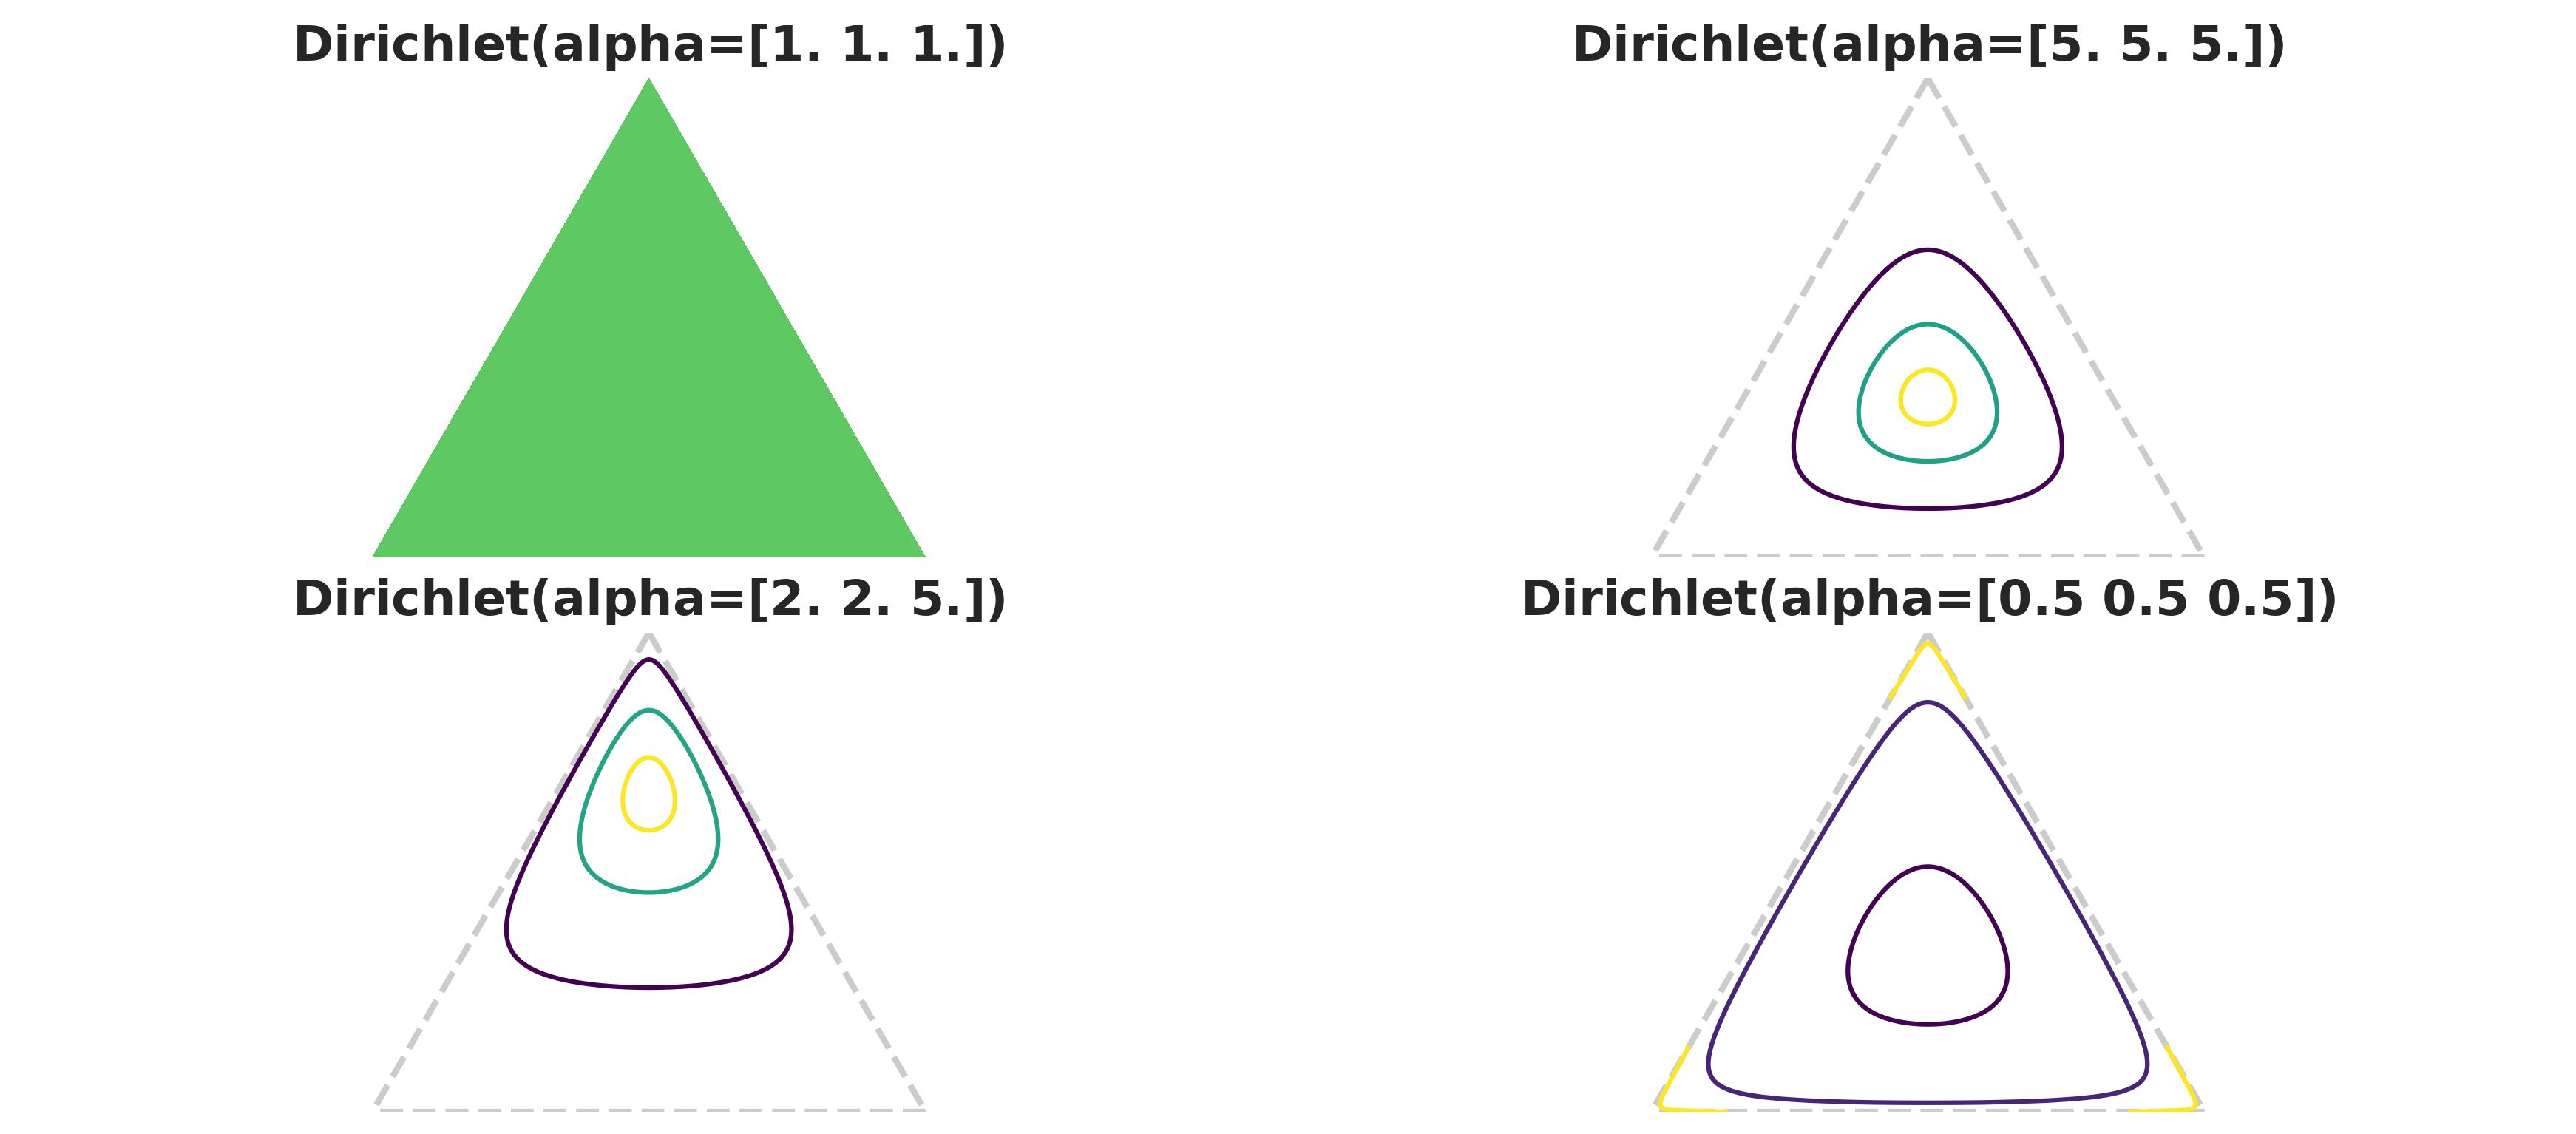

In [7]:
_, axes = plt.subplots(2, 2)
for a, ax in zip(([1,1,1], [5, 5, 5], [2, 2, 5], [0.5, 0.5, 0.5]), axes.ravel()):
    pz.Dirichlet(a).plot_pdf(marginals=False, ax=ax)

## Retomando el modelo de mezclas

<center>
<img src="../img/mezcla_finita_dag.png" width="500">

## Mezclas químicas

Vamos a utilizar los datos de desplazamientos químicos que ya vimos anteriormente.


![Histograma de desplazamientos químicos](../img/cs_exp_hist.png)




In [8]:
cs_exp = pd.read_csv("../datos/chemical_shifts_theo_exp.csv")["exp"]
cs_exp

0       58.27
1       56.18
2       56.84
3       51.01
4       54.64
        ...  
1771    57.51
1772    59.02
1773    58.92
1774    58.36
1775    60.55
Name: exp, Length: 1776, dtype: float64

## Implementando el modelo con variables latentes

<br>
<br>

```python
with pm.Model() as modelo_kg:
    w = pm.Dirichlet('w', a=np.ones(2))
    z = pm.Categorical('z', p=w, shape=len(cs_exp))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K)
    σ = pm.HalfNormal('σ', sigma=5)

    x = pm.Normal('x', mu=μ[z], sigma=σ, observed=cs_exp)
    idata_kg = pm.sample()
```

## Marginalizando la variable latente

* Muestrear $z$ de forma directa puede ser problemático
* Una forma de resolver esto es marginalizando la variable $z$:

\begin{split}
\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\sigma & \sim \mathcal{HN}(\dots) \\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
p(x)
    & = \sum_{i = 1}^K w_i\ N(x\ |\ \mu_i, \sigma^2)
\end{align*}
\end{split}


In [9]:
K = 2

with pm.Model() as modelo_mg:
    w = pm.Dirichlet('w', a=np.ones(K))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K)
    σ = pm.HalfNormal('σ', sigma=5)
    x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
az.summary(idata_mg, kind="diagnostics")

mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
w[0]      0.177    0.135       7.0      33.0   1.53
w[1]      0.177    0.135       7.0      33.0   1.53
μ[0]      2.292    1.755       7.0      28.0   1.53
μ[1]      2.289    1.753       7.0      28.0   1.53
σ         0.001    0.001    4473.0    3396.0   1.00

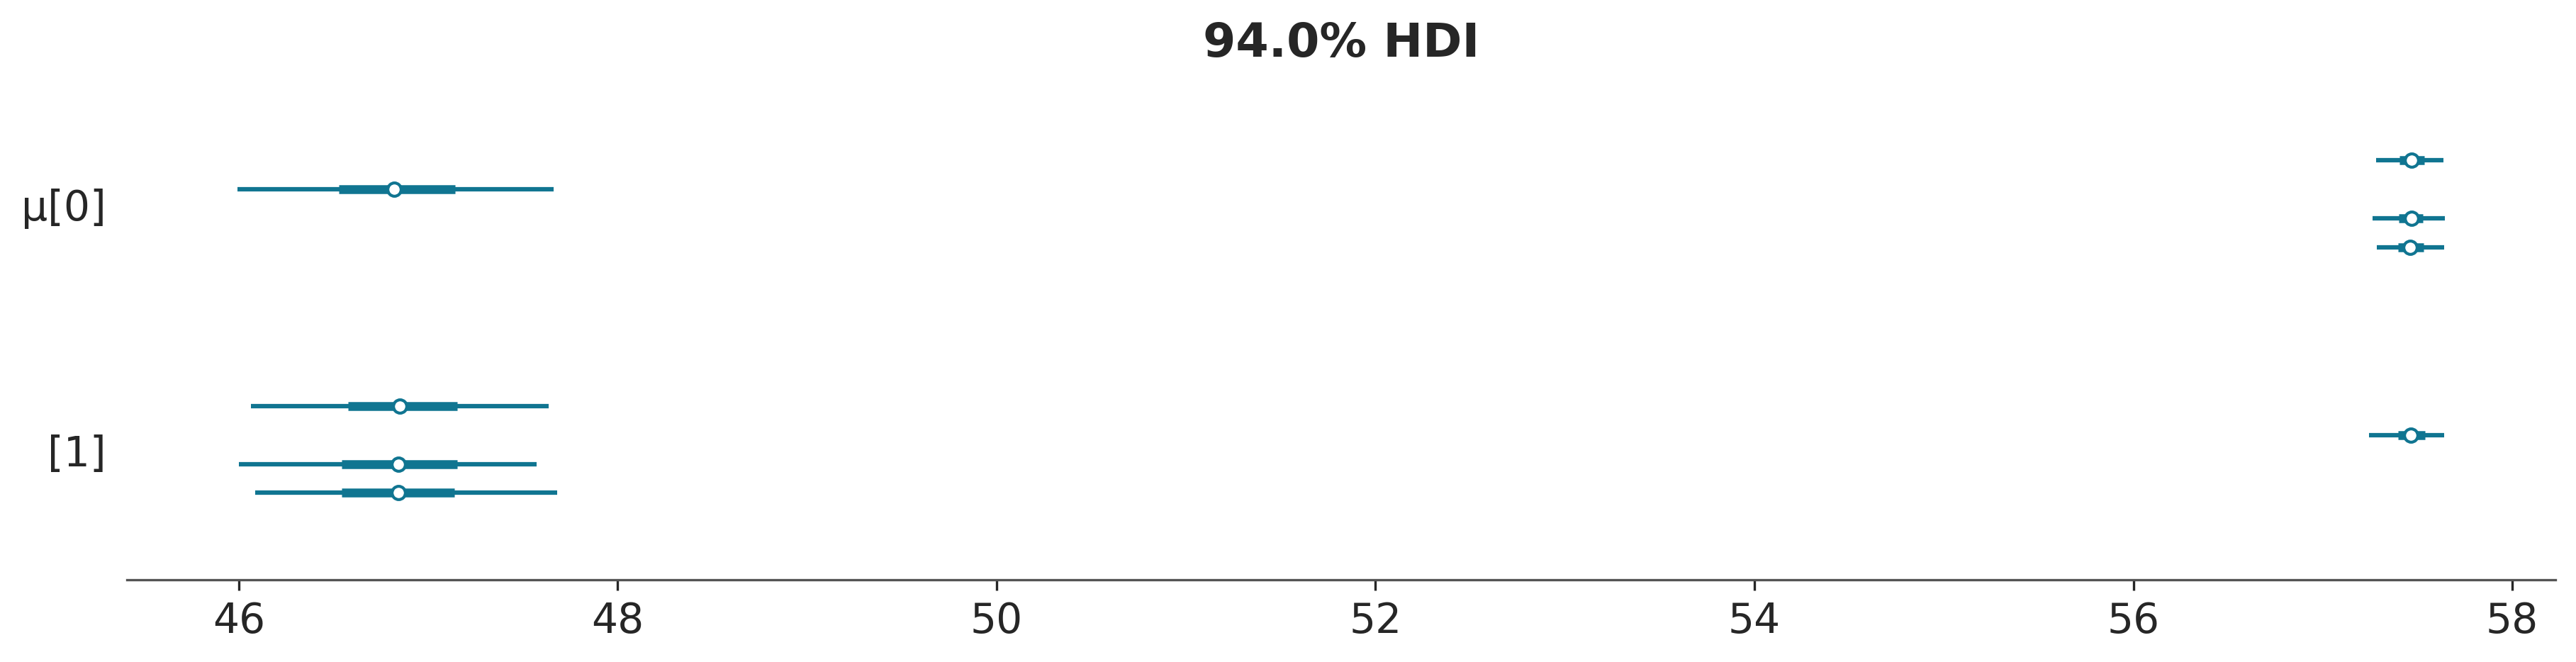

In [11]:
az.plot_forest(idata_mg, var_names="μ", figsize=(12, 3));

## No-identificabilidad

<br>

> Un modelo estadístico es no-identificable si uno o más de sus parámetros no pueden determinarse de forma única. 

* Los parámetros de un modelo no se identifican si se obtiene la misma función de verosimilitud para más de un conjunto de parámetros. 
* Esto sucede cuando los datos no contienen suficiente información para estimar los parámetros
* También es posible que el modelo sea estructuralmente no-identificable

<br>

## No-identificabilidad II

<br>

* Cuando un modelo es no identificable, en generar el posible convertirlo en identificable si agregamos alguna restricción extra
* Con los modelos mixtos, existen al menos dos formas de parametrizar un modelo para eliminar el problema de la no identificabilidad. 
    * Podemos forzar un orden arbitrario en los componentes; por ejemplo, establecer que el vector $\mu$ debe ser estrictamente creciente 
    * O podemos usar priors informativos. 
    


In [12]:
with pm.Model() as modelo_mgo:
    w = pm.Dirichlet('w', a=np.ones(K))
    μ = pm.Normal('μ', mu=cs_exp.mean(), sigma=10, shape=K,
                 transform=pm.distributions.transforms.ordered, 
                 initval=np.array([cs_exp.mean()-1, cs_exp.mean()+1]),
                 )
    σ = pm.HalfNormal('σ', sigma=5)
    x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)    
    
    idata_mgo = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


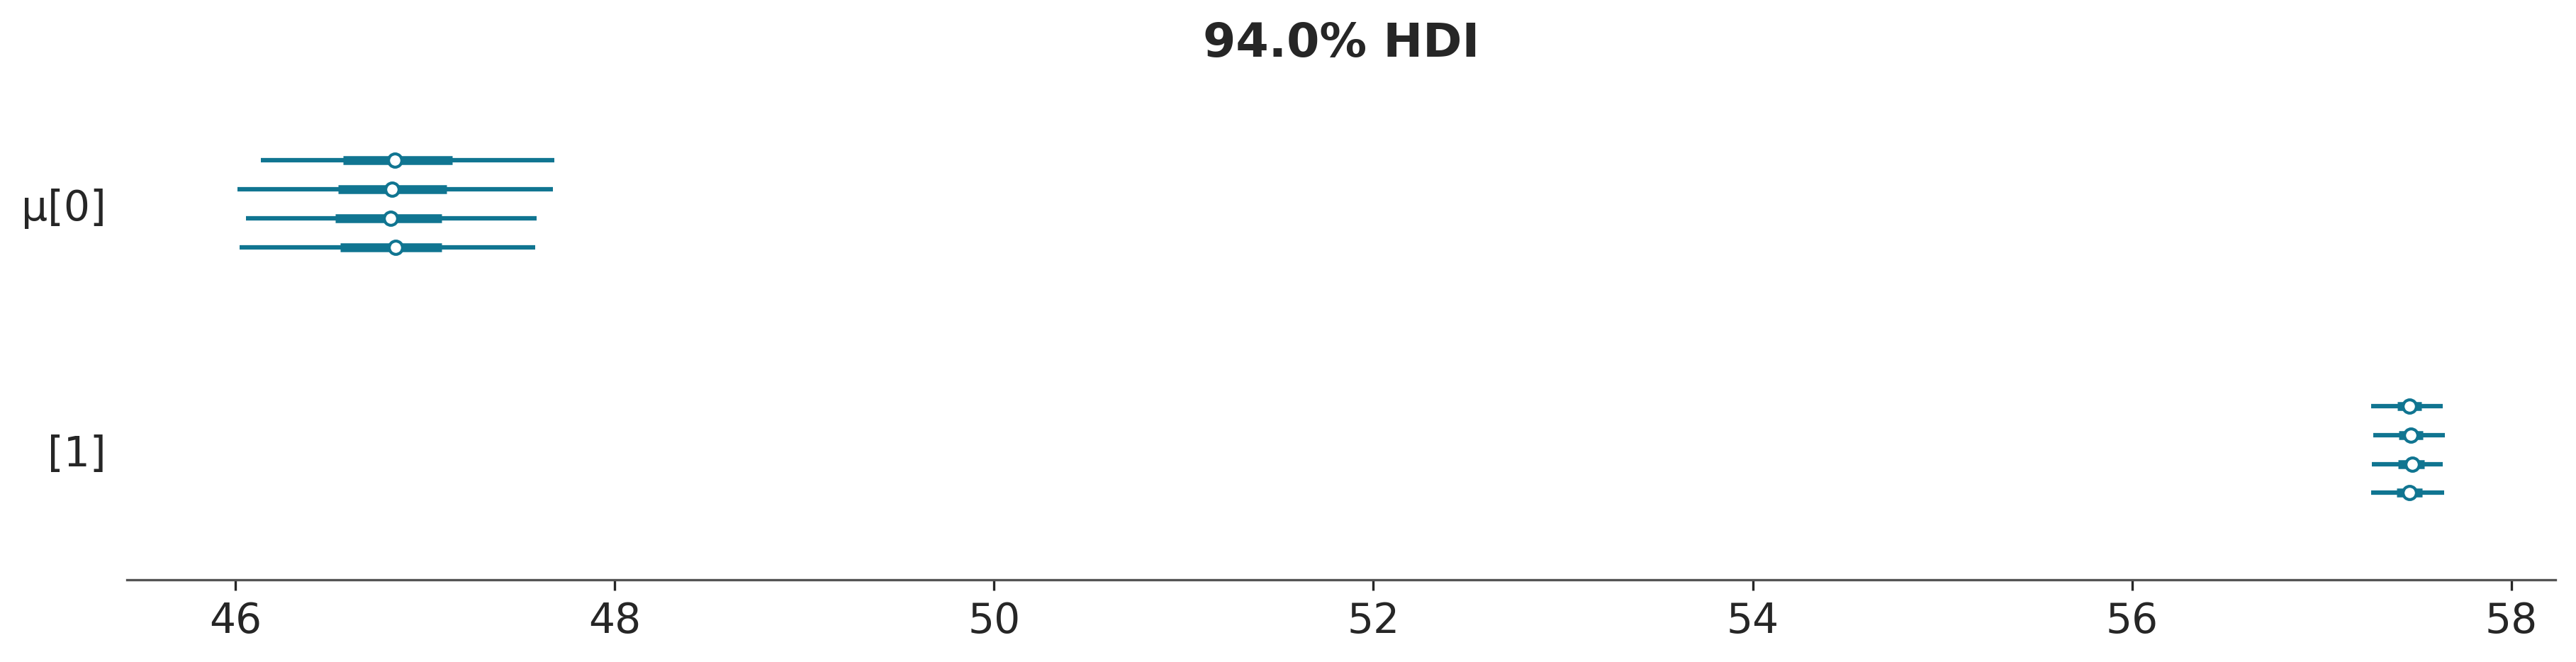

In [13]:
az.plot_forest(idata_mgo, var_names="μ", figsize=(12, 3));

## Como elegir K

<br>
<br>

* Una de las principales preocupaciones con los modelos de mezclas finitas es cómo decidir el número de componentes. 
* En muchos problemás el conocimiento de dominio puede determinar $K$, o proveer de valores razonables
* Si $K$ es desconocido podemos ajustar varios modelos, para distintos valores de $K$ y luego evaluar su ajuste.

<br>
<br>

In [14]:
Ks = [2, 3, 4, 5]

models = []
idatas = []
for k in Ks:
    with pm.Model() as model:
        w = pm.Dirichlet('w', a=np.ones(k))
        μ = pm.Normal('μ',
                      mu=np.quantile(cs_exp, np.linspace(0.1, 0.9, k)),
                      sigma=cs_exp.var() / k,
                      shape=k,
                      transform=pm.distributions.transforms.ordered,
                     )
        σ = pm.HalfNormal('σ', sigma=5)
        x = pm.NormalMixture('x', w=w, mu=μ, sigma=σ, observed=cs_exp)
        idata = pm.sample(random_seed=123,
                          idata_kwargs={"log_likelihood":True}
                         ) 
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


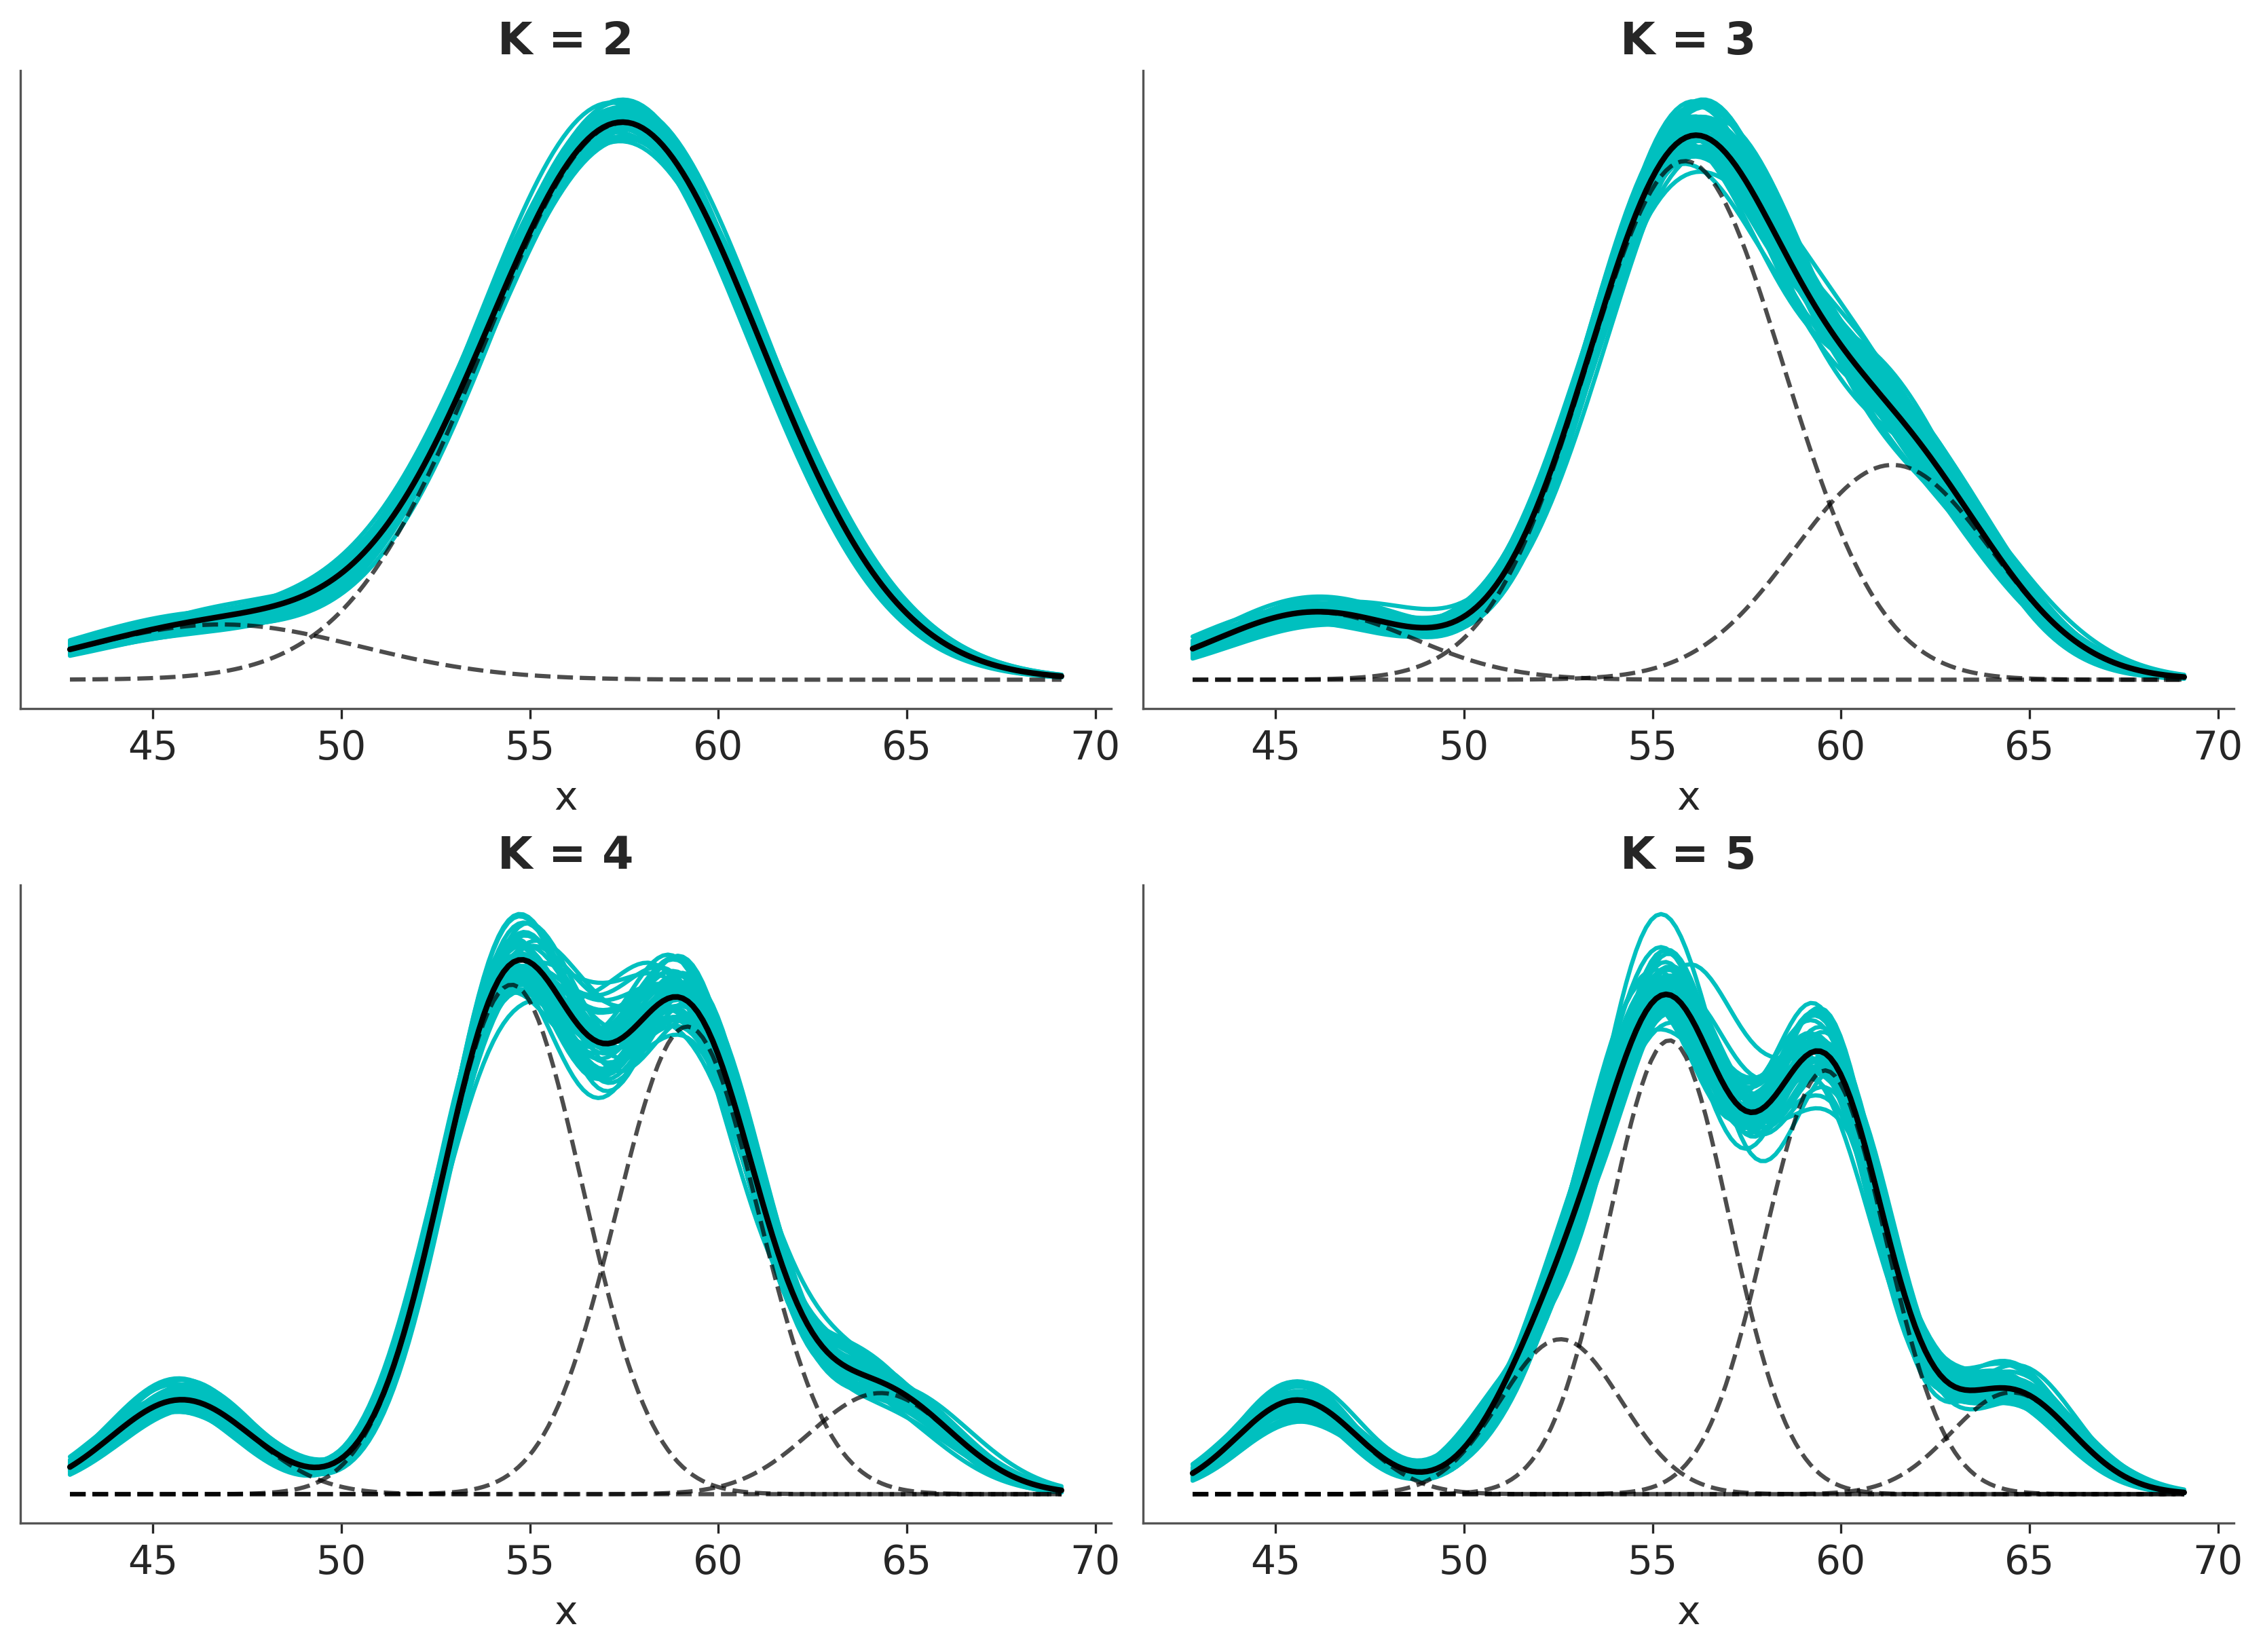

In [15]:
#| code-fold: true
_, ax = plt.subplots(2, 2, figsize=(11, 8))
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * Ks[idx]).T

    for i_ in np.random.randint(0, posterior_x.samples.size, size=50):
        dist = pz.Normal(posterior_x['μ'][:,i_], posterior_x['σ'][i_])
        ax[idx].plot(x, np.sum(dist.pdf(x_) *  posterior_x['w'][:,i_].values, 1), 'C1')
 
    p_y = posterior_x['w'].mean("samples")
    dist = pz.Normal(posterior_x['μ'].mean("samples"), posterior_x['σ'].mean())
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'k', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    ax[idx].set_title('K = {}'.format(Ks[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

Sampling: [x]
Sampling: [x]
Sampling: [x]
Sampling: [x]


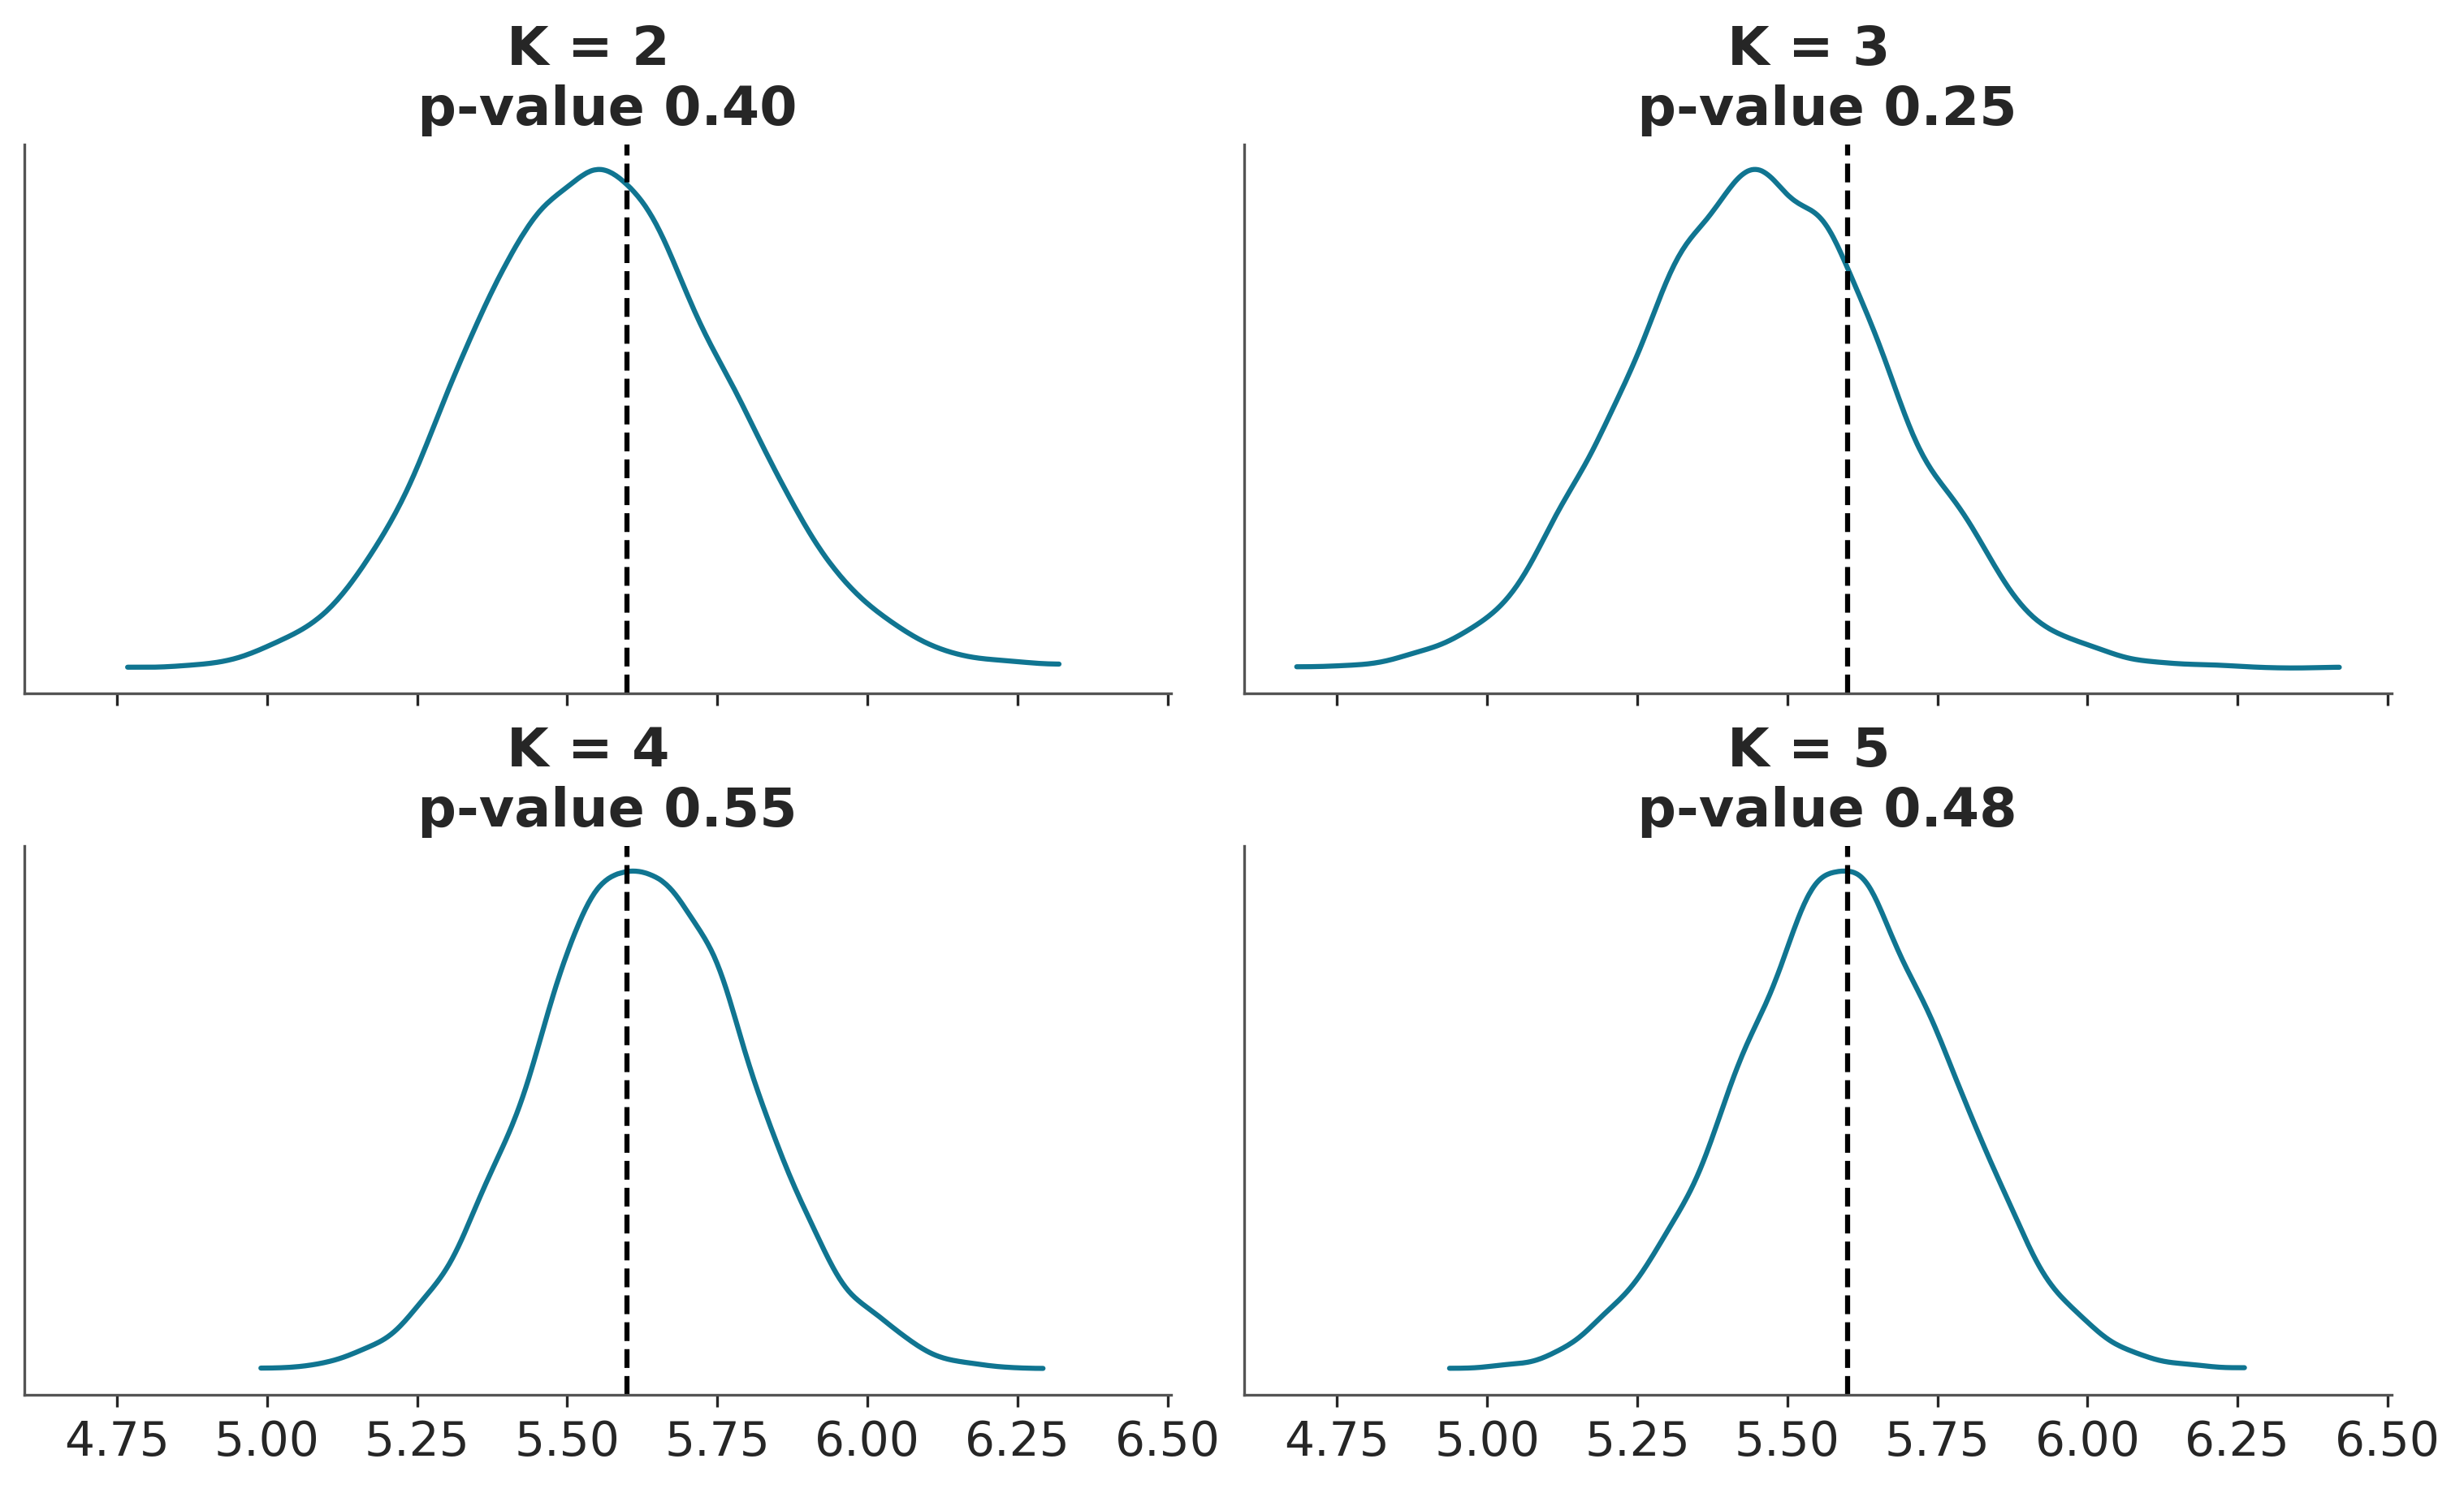

In [16]:
#| code-fold: true
ppc_mm = [pm.sample_posterior_predictive(idatas[i],
                                         models[i],
                                         random_seed=4591,
                                         progressbar=False) for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))
    
T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    d_sim = d_sim.posterior_predictive["x"]
    T_sim = iqr(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {Ks[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

In [17]:
comp = az.compare(dict(zip([str(K) for K in Ks], idatas)))
comp

rank     elpd_loo     p_loo  elpd_diff        weight         se        dse  \
5     0 -5129.384194  9.970668   0.000000  1.000000e+00  30.772529   0.000000   
4     1 -5139.675594  7.686262  10.291400  0.000000e+00  31.282253   3.888748   
3     2 -5178.424336  5.874284  49.040142  0.000000e+00  31.903651   8.746907   
2     3 -5215.947340  3.299947  86.563146  2.437162e-11  33.504264  11.930113   

   warning scale  
5    False   log  
4    False   log  
3    False   log  
2    False   log

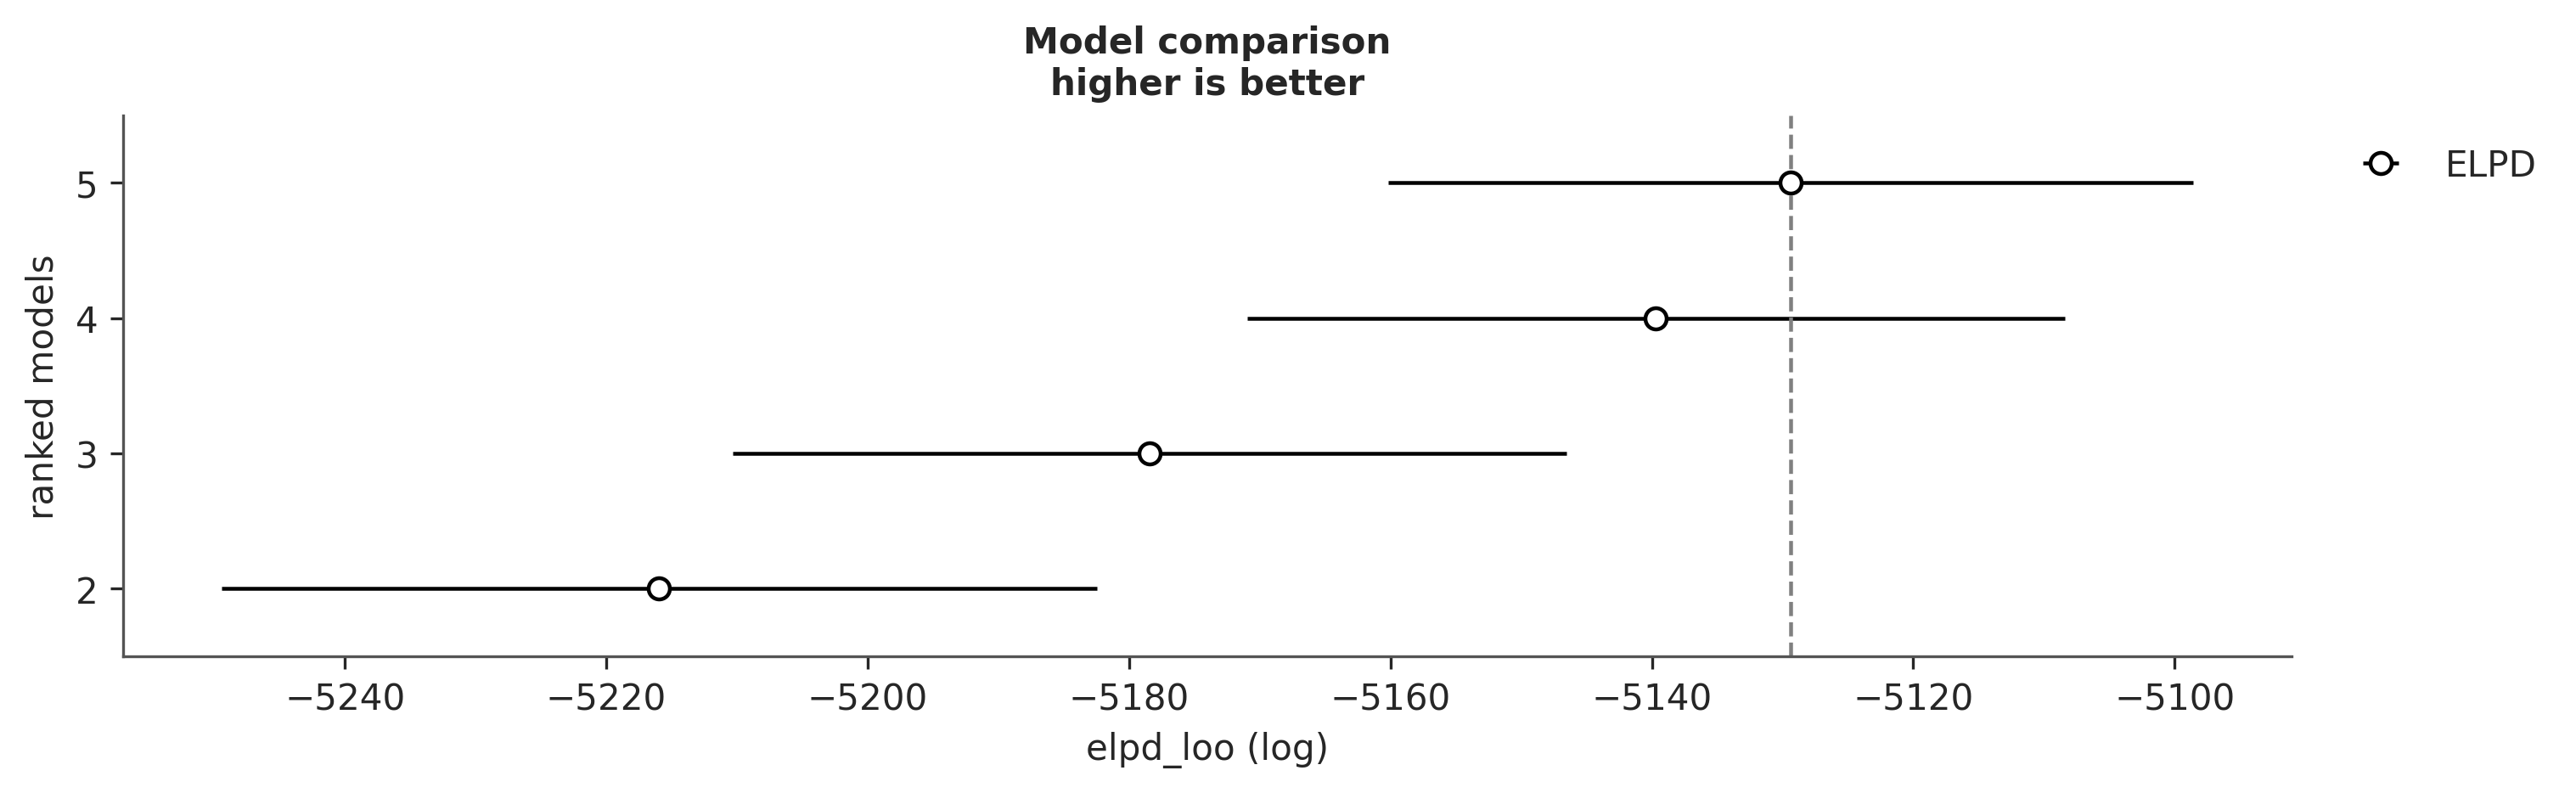

In [18]:
az.plot_compare(comp, figsize=(10, 3), plot_ic_diff=False);

## Modelos de mezclas disfrazados

<br>
<br>

> Muchos modelos/distribuciones puede considerarse mezclas de distribuciones

* Student's t: Mezcla de Gaussianas donde las varianzas se distribuyen siguiendo una distribución Gamma Inversa.
* Negative Binomial: Mezcla de Poisson cuya tasa se distribuye como una Gamma

Hay otros ejemplos más "evidentes"

<br>

## Ser o no ser

<br>
<br>

* Al contar cosas, como autos en una ruta, estrellas en el cielo, lunares en la piel una posiblidad es contar cero. 
* Podemos obtener cero por muchas razones; podemos contar 0 autos rojos, por que ninguno pasó o por que pasó uno detras de un camión y no lo pudimos ver. 
* Si utilizamos una distribución Poisson o NegativaBinomial para modelar dichos datos, es posible que notemos que el modelo genera menos ceros en comparación con los datos.

<br>

## Mezcla de dos procesos

<br>
<br>

* Una forma de considerar ceros "extra" es pensar que nuestras observaciones se generan como una mezcla de dos procesos:
    * Uno modelado por una distribución discreta con probabilidad $\psi$
    * Uno dando ceros adicionales con probabilidad $1 - \psi$
    
<br>



## Distribuciones zero-infladas

<br>
<br>

* La familia de distribuciones que permiten ceros "adicionales" se conoce como distribución cero-infladas (o infladas en cero). 
* Los miembros más comunes de esa familia son:
    * Poisson inflada en cero
    * NegativaBinomial inflada en cero
    * Binomial inflada en cero
    
<br>

## PDF distribuciones zero-infladas

Dada una distribución base con función de masa de probabilidad (PMF). Podemos describir una distribución zero-inflada como:

\begin{split}
f(x \mid \psi, n, p) = \left\{ \begin{array}{l}
    (1-\psi) + \psi \; \text{PMF}(0), \text{si } x = 0 \\
    \psi \; \text{PMF}(x), \text{si } x=1,2,3,\ldots,n
    \end{array} \right.
\end{split}

En la siguiente sección, usaremos Poisson inflado de ceros para resolver un problema de regresión.

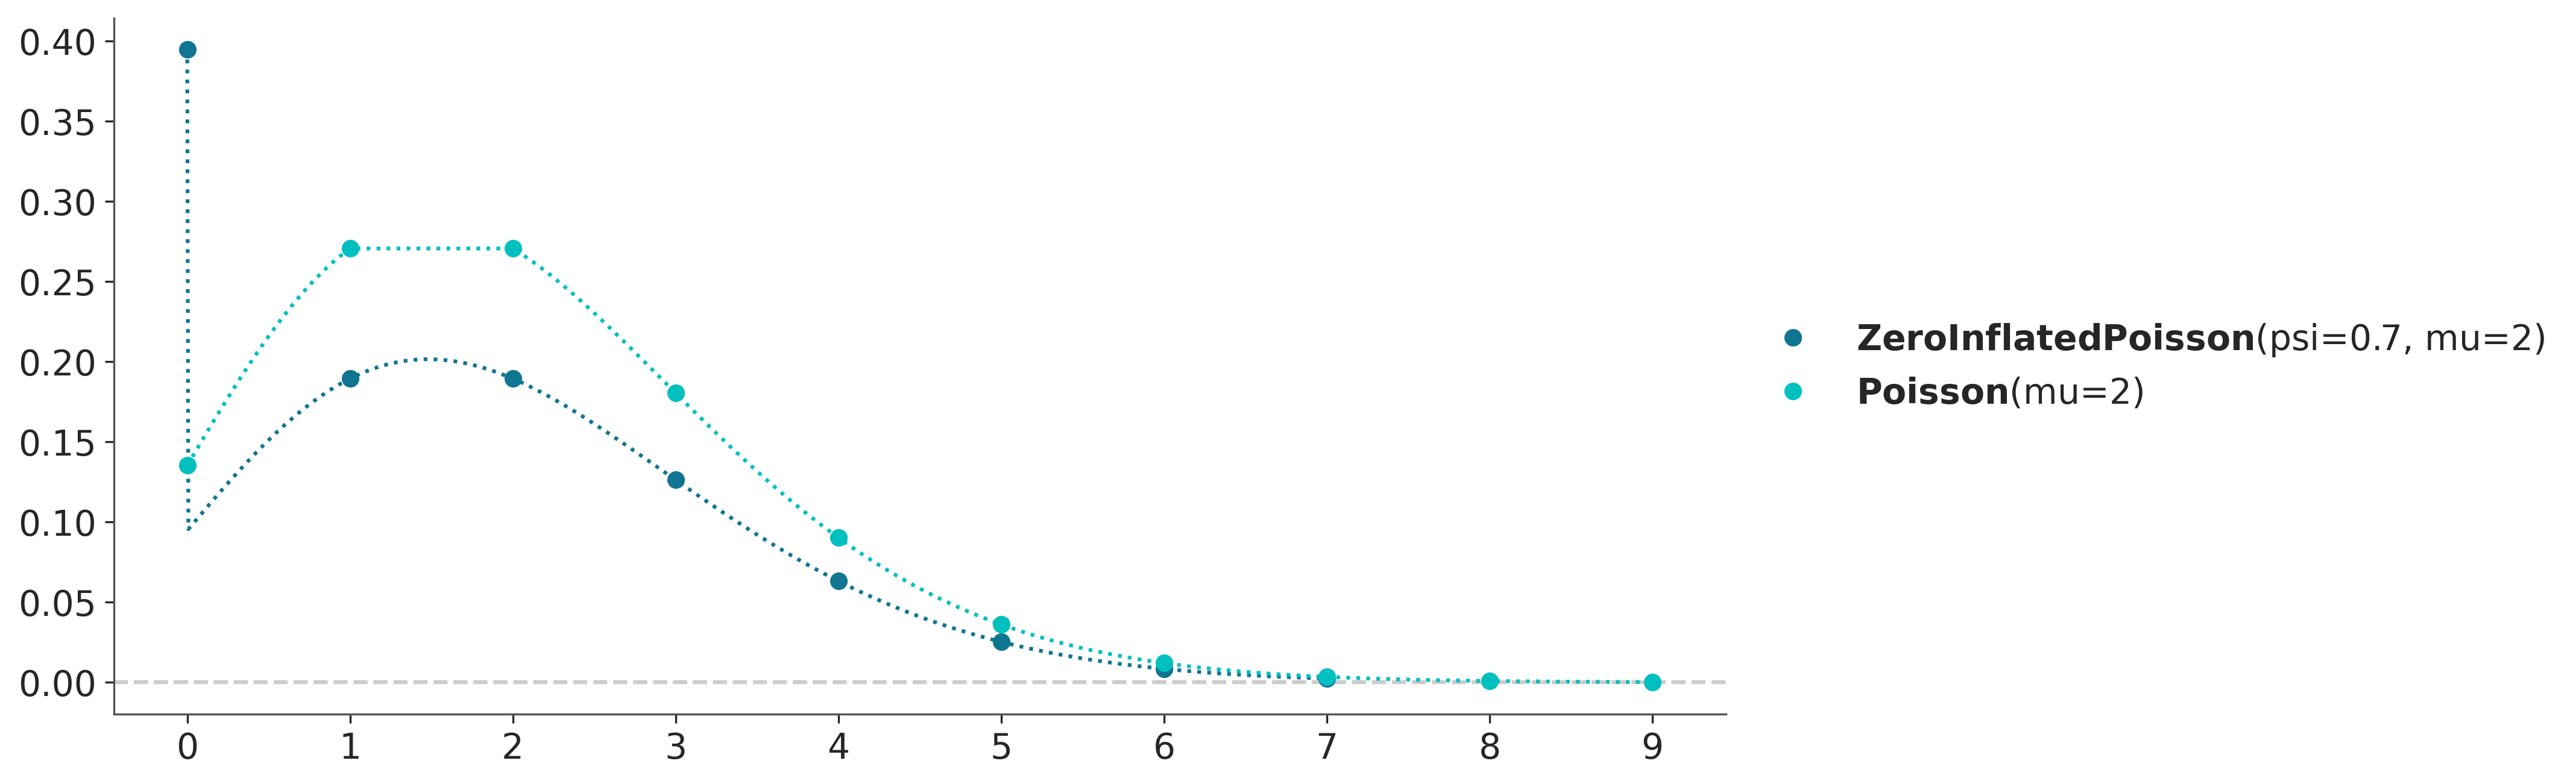

In [19]:
pz.ZeroInflatedPoisson(psi=0.7, mu=2).plot_pdf()
pz.Poisson(mu=2).plot_pdf();

## Regresión de Poisson inflada en cero

* Tenemos 250 grupos de visitantes a un parque
* Para cada grupo tenemos el registro de la cantidad de peces que capturaron `count`, cuántos niños había en el grupo `child` y si trajeron una casa-rodante/caravana al parque `camper`.
* Usando estos datos, vamos a construir un modelo de la cantidad de peces capturados en función de las variables del niño y del campista.


In [20]:
pesca = pd.read_csv('../datos/pesca.csv')

In [21]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=2)
    θ = pm.math.exp(α + β[0] * pesca['child'] + β[1] * pesca['camper'])
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=pesca['count'])
    idata_ZIP_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ψ, α, β]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


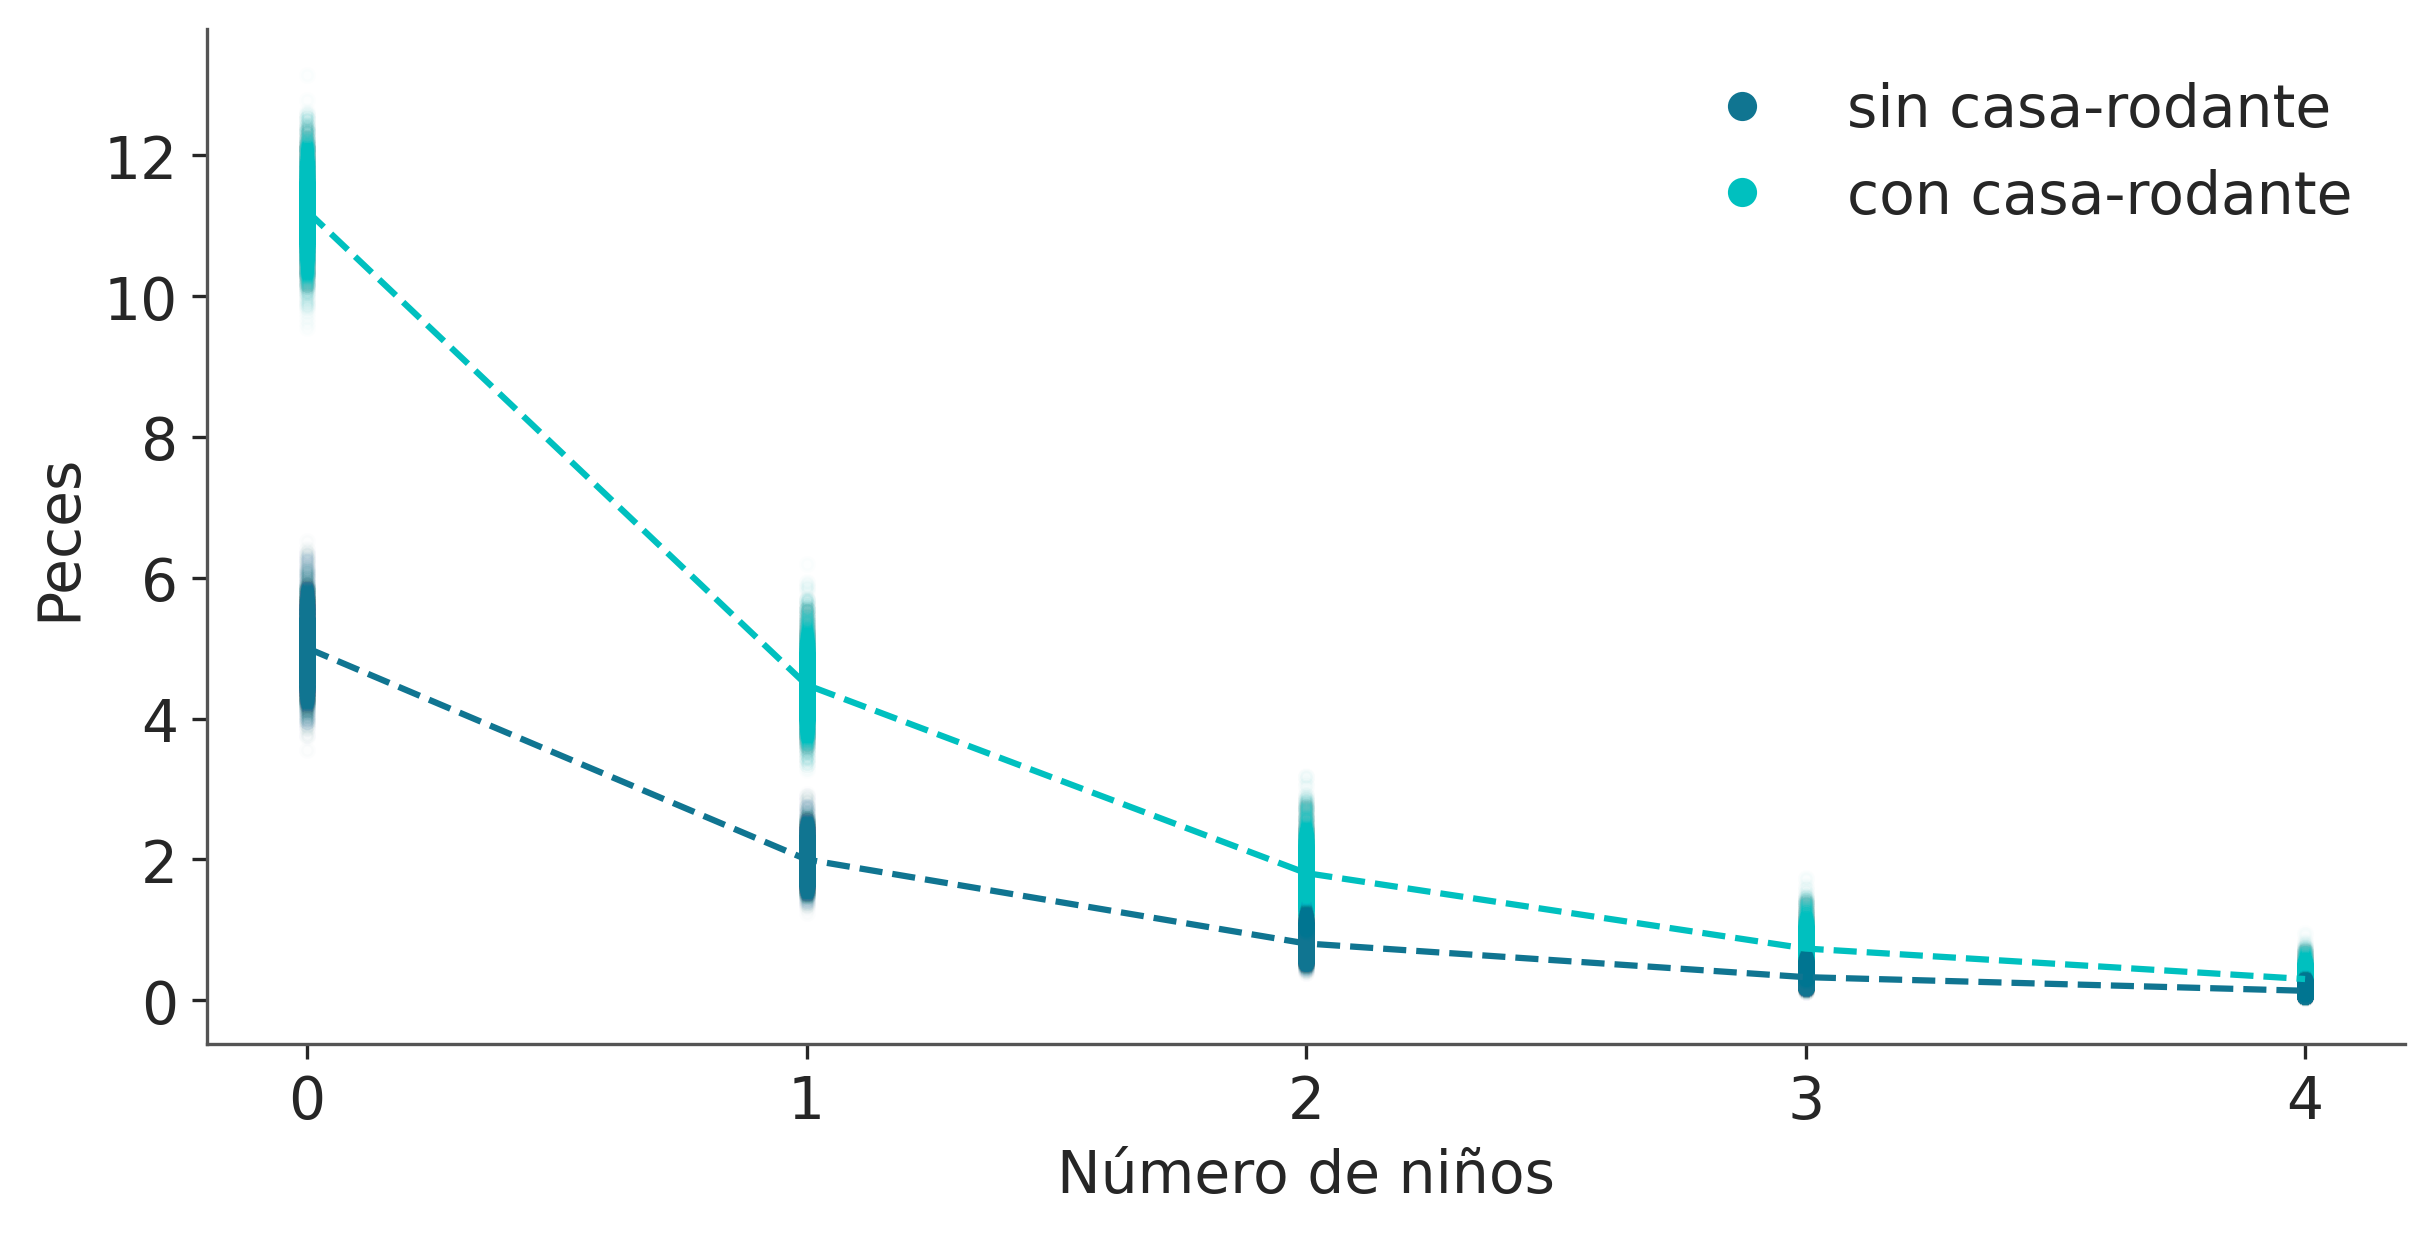

In [22]:
#| code-fold: true
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []

posterior = az.extract(idata_ZIP_reg)

without_camper = posterior['α'] + posterior['β'][0] * xr.DataArray(children)
with_camper = without_camper + posterior['β'][1]
fish_count_pred_0 = np.exp(without_camper)
fish_count_pred_1 = np.exp(with_camper)

_, ax = plt.subplots(figsize=(8, 4))
ax.plot(children, fish_count_pred_0.T, 'C0.', alpha=0.01)
ax.plot(children, fish_count_pred_1.T, 'C1.', alpha=0.01)
ax.plot(children, fish_count_pred_0.mean("sample"), 'C0', ls="--")
ax.plot(children, fish_count_pred_1.mean("sample"), 'C1', ls="--")
ax.set_xticks(children)
ax.set_xlabel('Número de niños')
ax.set_ylabel('Peces')
ax.plot([], 'C0o', label='sin casa-rodante')
ax.plot([], 'C1o', label='con casa-rodante')
plt.legend();

## Modelos hurdle

<br>
<br>

* Los modelos de hurdle (obstáculo), también se describien como una mezcla de dos procesos
    * Los ceros vienen dados **exclusivamente** con probabilidad $1 - \psi$
    * Los valores positivos vienen dados por una distribución base truncada en cero. 

<br>

## Modelos hurdle II

<br>
<br>
Como consecuencia, un modelo inflado en cero solo puede aumentar la probabilidad de $P(x= 0)$, 

* Para los modelos hurdle, la probabilidad $P(x= 0)$ puede ser mayor o menor que en la distribución base.
* En los modelos inflados en cero $P(x= 0)$ solo puede ser mayor o igual (en el caso que se reduce a la distribución base).

<br>

## Modelos hurdle III

<br>
<br>

Algunas distribuciones "hurdle" comunmente usadas son: 

* Poisson Hurdle
* NegativaBinomial Hurdle
* Gamma Hurdle
* Normal Hurdle


Dada una distribución base con función de distribución acumulada (CDF) y función de masa/densidad de probabilidad (PDF). Podemos describir una distribución Hurdle como:

\begin{split}f(x \mid \psi, \mu) =
    \left\{
        \begin{array}{l}
        (1 - \psi)  \ \text{si } x = 0 \\
        \psi
        \frac{\text{PDF}(x \mid \mu))}
        {1 - \text{CDF}(0 \mid \mu)} \ \text{si } x \not= 0\ldots
        \end{array}
    \right.
\end{split}


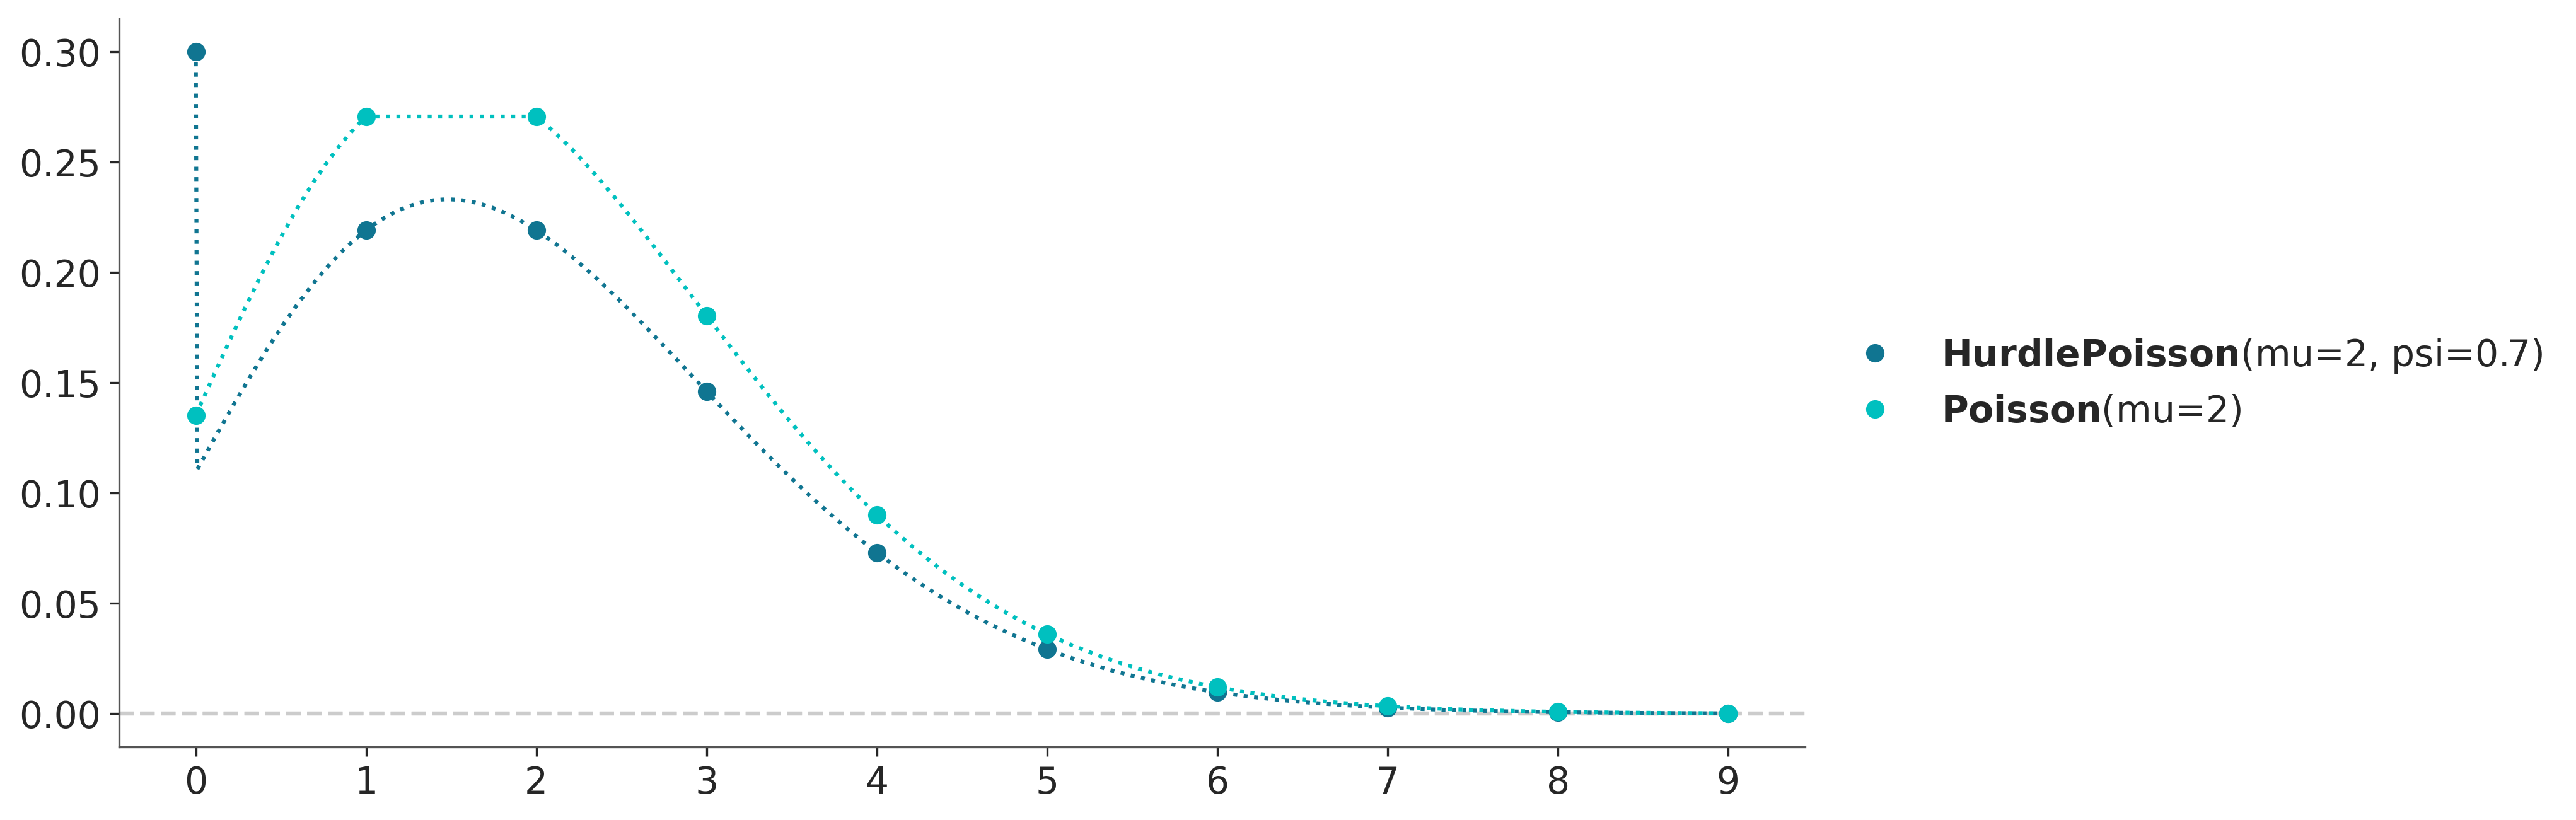

In [23]:
pz.Hurdle(pz.Poisson(mu=2), psi=0.7).plot_pdf()
pz.Poisson(mu=2).plot_pdf();

/home/osvaldo/anaconda3/envs/EI2/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:287: RuntimeWarning: divide by zero encountered in nb_logpdf
  return super().__call__(*args, **kws)


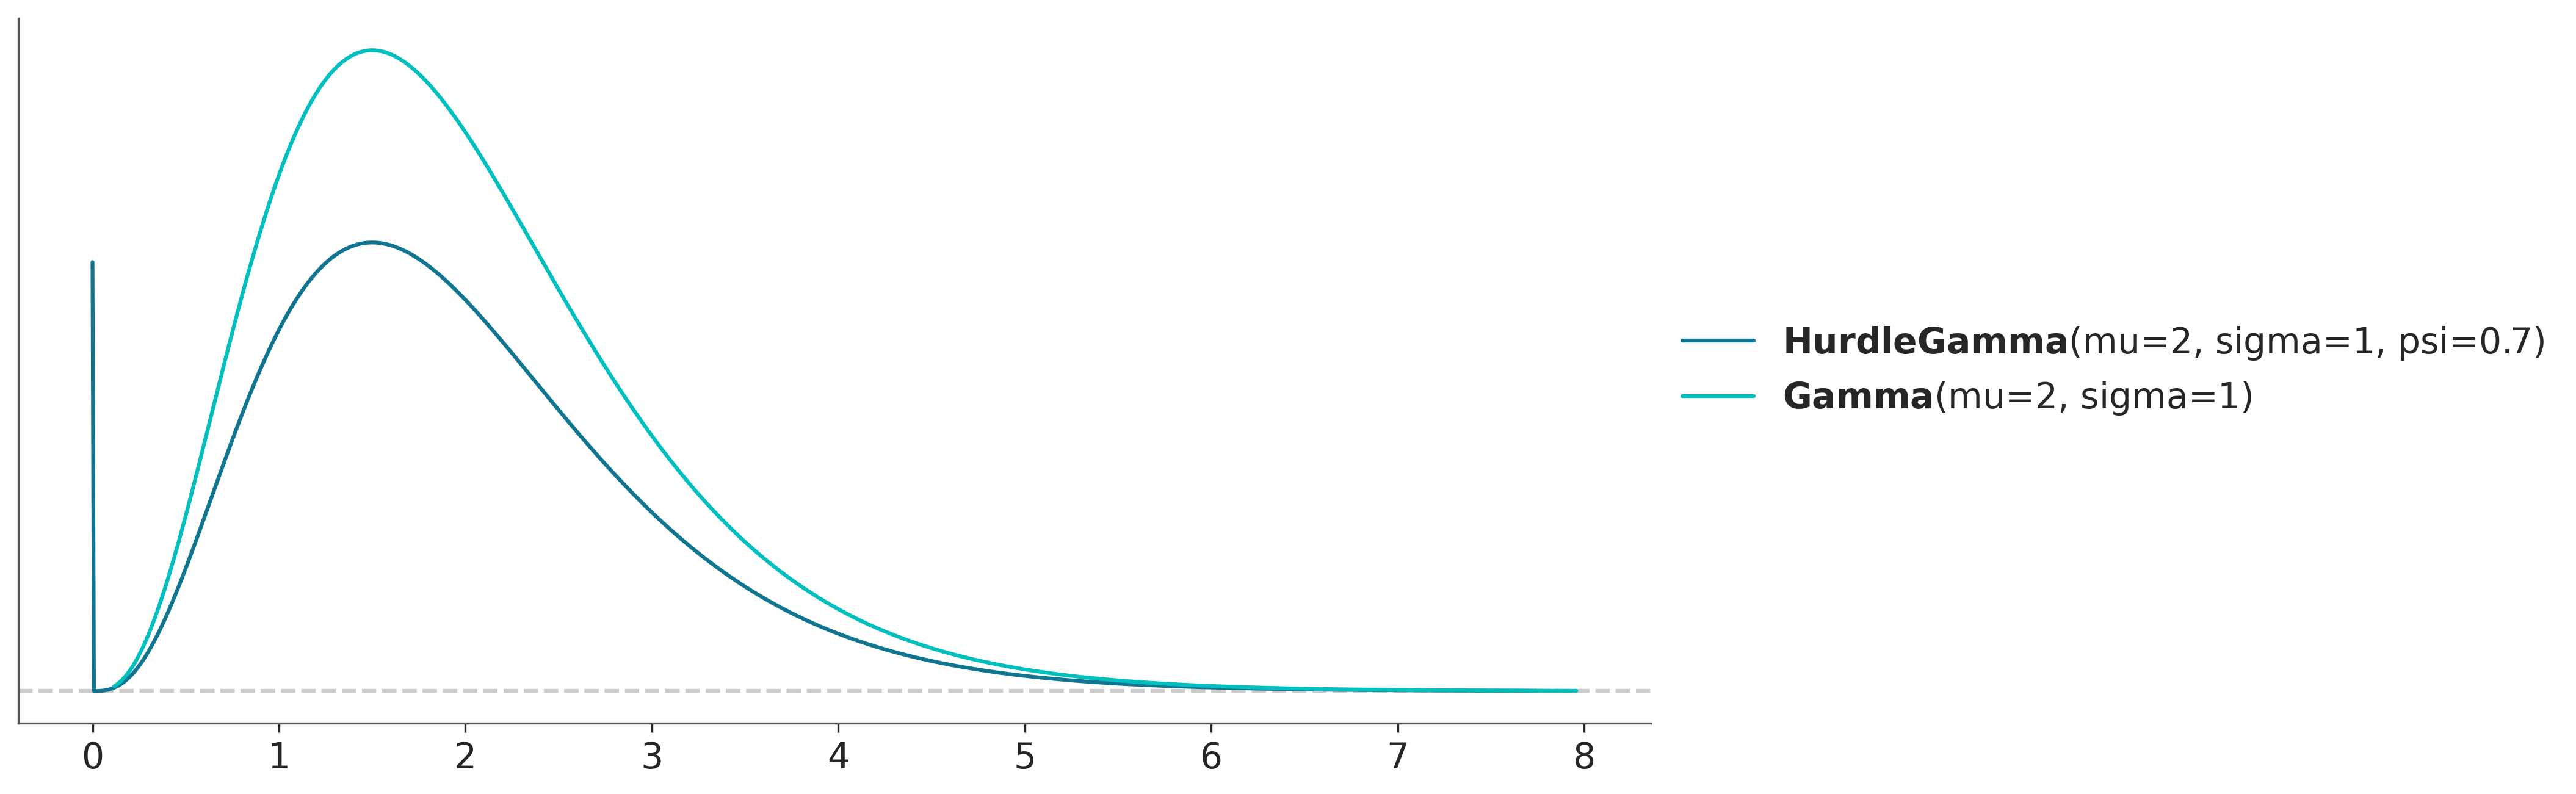

In [24]:
pz.Hurdle(pz.Gamma(mu=2, sigma=1), psi=0.7).plot_pdf()
pz.Gamma(mu=2, sigma=1).plot_pdf();

## Cangrejos herradura

Vamos a utilizar el conjunto de datos del cangrejo herradura [Brockmann_1996](https://onlinelibrary.wiley.com/doi/10.1111/j.1439-0310.1996.tb01099.x). 

* Los cangrejos herradura llegan a la playa en parejas para su ritual de desove. 
* Los machos solitarios  se agrupan alrededor de las parejas que anidan y compiten por la oportunidad de fertilizar los huevos. 
* Estos individuos, conocidos como machos satélites, a menudo se congregan cerca de ciertas parejas, e ignoran a otras. 
* Sospechamos que el número de `satelites` está relacionado con las propiedades de los caparazones de las hembras como `width` y `color`. 

In [25]:
crab = pd.read_csv("../datos/horseshoe_crab.csv")
crab.head()

color  spine  width  satellite  weight
0      2      3   28.3          8    3050
1      3      3   22.5          0    1550
2      1      1   26.0          9    2300
3      3      3   24.8          0    2100
4      3      3   26.0          4    2600

In [26]:
familias = ["poisson", "hurdle_poisson", "negativebinomial", "hurdle_negativebinomial"]

modelos = []
idatas = []

for familia in familias:
    modelo = bmb.Model("satellite ~ width + C(color)", family=familia, data=crab)
    idata = modelo.fit(idata_kwargs={"log_likelihood":True}, random_seed=123)
    modelo.predict(idata, kind="pps")
    idatas.append(idata)
    modelos.append(modelo)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_psi, Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_alpha, Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [satellite_psi, satellite_alpha, Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [27]:
cmp = az.compare(dict(zip(familias, idatas)))
cmp

rank    elpd_loo      p_loo  elpd_diff        weight  \
hurdle_negativebinomial     0 -372.673065   6.165628   0.000000  3.249791e-14   
negativebinomial            1 -380.355948   5.654806   7.682883  4.159461e-01   
hurdle_poisson              2 -382.383904   8.625863   9.710839  5.840539e-01   
poisson                     3 -468.366716  16.124878  95.693651  0.000000e+00   

                                se        dse  warning scale  
hurdle_negativebinomial  13.672084   0.000000    False   log  
negativebinomial         14.122017   5.692175    False   log  
hurdle_poisson           17.712628   6.637519    False   log  
poisson                  24.794667  19.477914    False   log

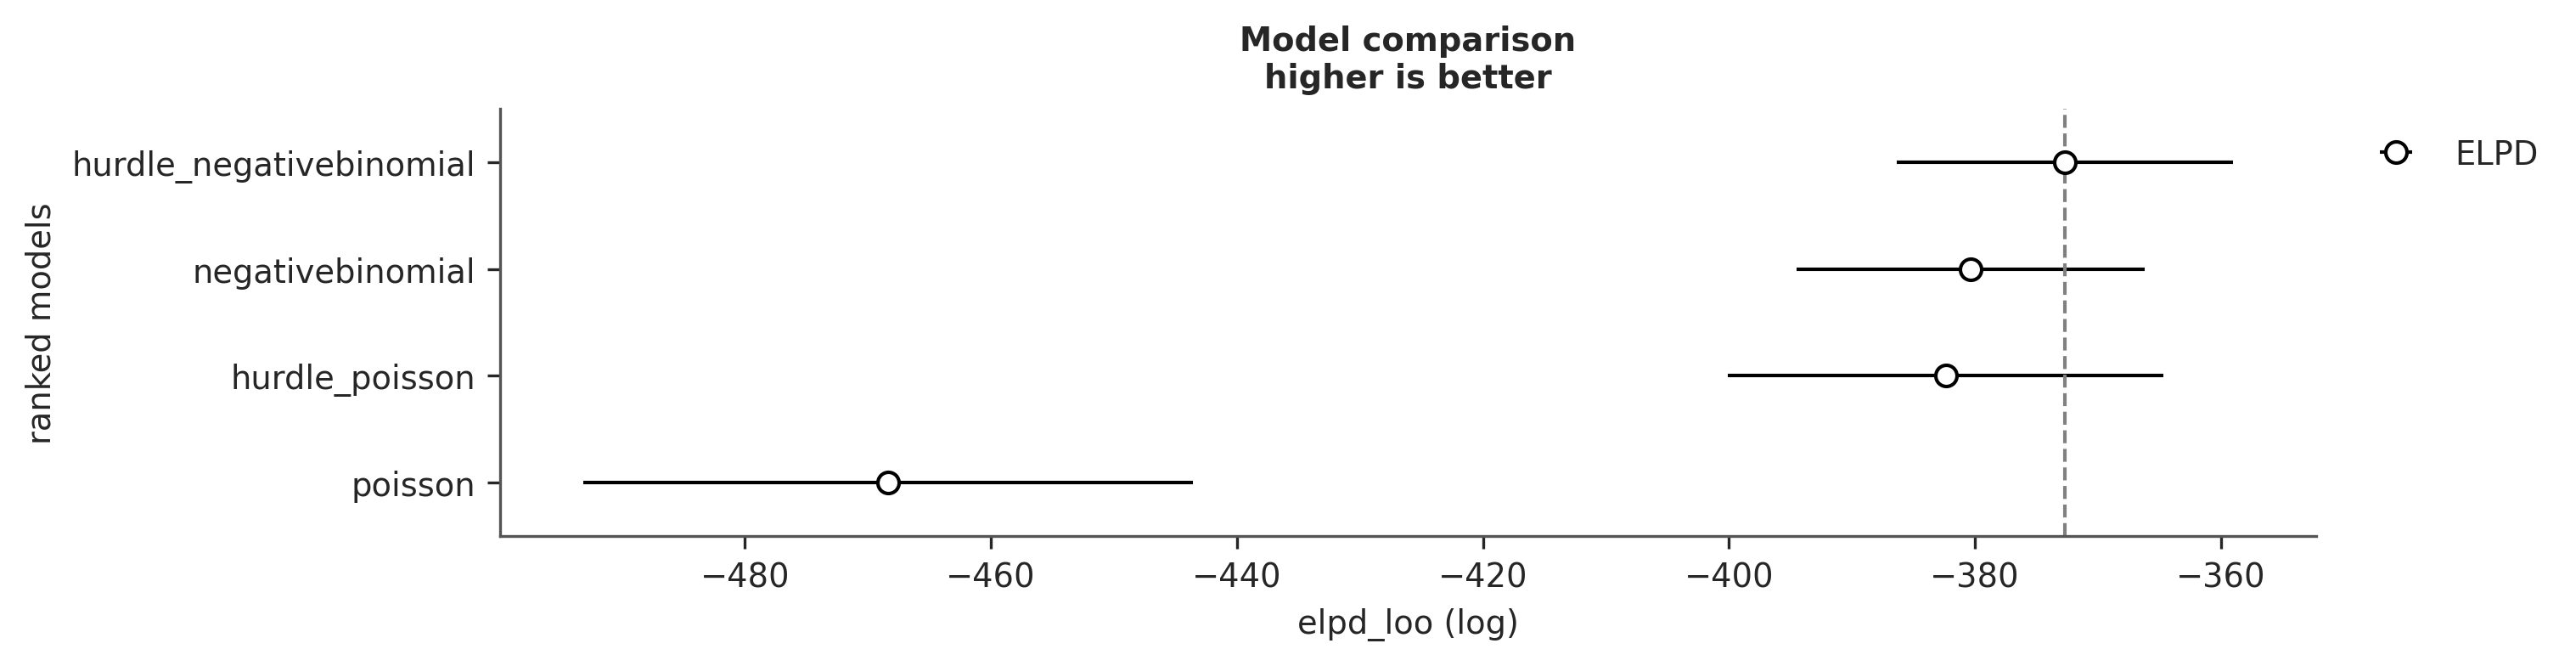

In [28]:
az.plot_compare(cmp, figsize=(10, 2.5), plot_ic_diff=False);

## Hanging rootograms

* Es un gráfico de barras pensado para evaluar distribuciones/modelos de conteo
* Se dibujan las raíces cuadradas de los valores observados y predichos. 
    * Esto facilita la comparación de frecuencias observadas y esperadas incluso para frecuencias bajas. 
* Las barras representan los datos observados y en vez de *crecer* desde el cero, *cuelgan* desde los valores esperados.
* Si la barra _cae_ por debajo de cero entonces el modelo está subestimando ese valor, y si no _alcanza_ al cero es que lo está sobreestimando.

/tmp/ipykernel_5616/424556328.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = dims["chain"] * dims["draw"]


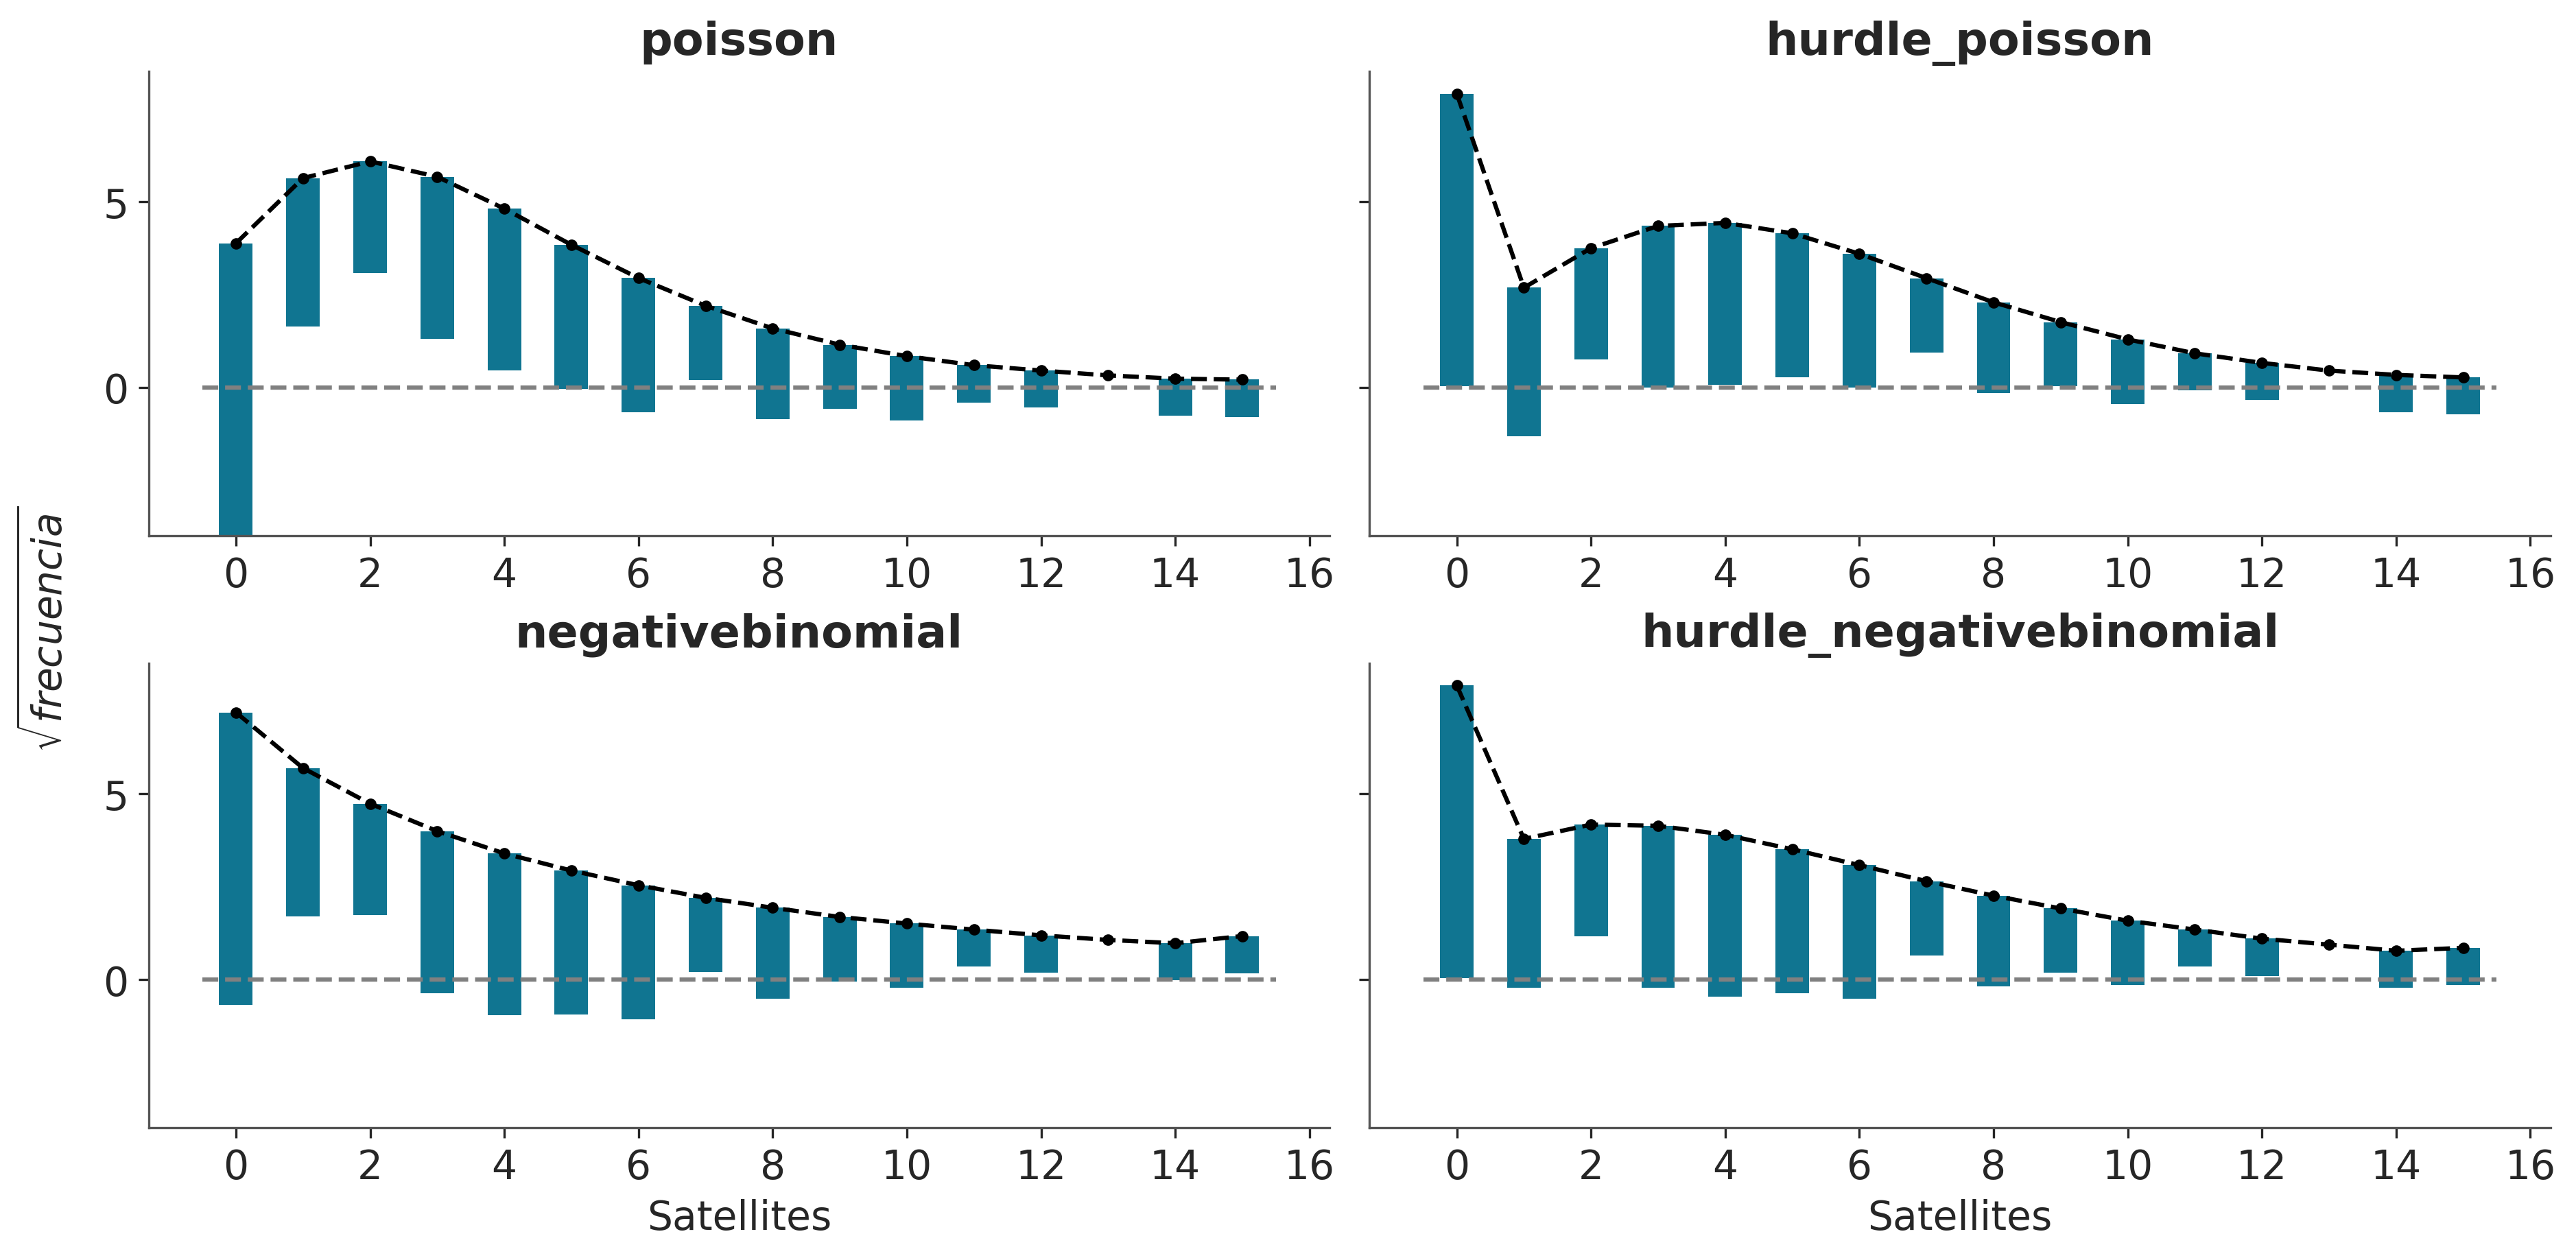

In [29]:
#| code-fold: true

def rotogram(idata, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    dims = idata.posterior_predictive.dims
    n_samples = dims["chain"] * dims["draw"]
    pred =  (np.histogram(idata.posterior_predictive["satellite"].values.ravel(),  bins=bins)[0] / n_samples)**0.5
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]**0.5

    ax.bar(bins[:-1], observed, 0.5, bottom=pred-observed, color="C0")
    ax.plot(bins[:-1], pred,  "k.--")
    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="0.5")


fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 6))
for ax, idata, model in zip(axes.ravel(), idatas, modelos):
    rotogram(idata, ax)
    ax.set_title(model.family.name)

axes[1,1].set_xlabel("Satellites")
axes[1,0].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "$\sqrt{frecuencia}$", va="center", rotation="vertical", fontsize=14);

## Bayesian Rootograms

<br>

* Los rootogramas tradicionales no tienen en cuenta la incertidumbre de los valores predichos.

* ArviZ no soporta, aún, rootograms. Pero lo hará pronto, por el momento la propuesta es:


![](https://arviz-devs.github.io/Exploratory-Analysis-of-Bayesian-Models/img/rootogram_hanging.png)


## Modelos mixtos no-finitos

<br>
<br>

* Como ya discutimos definir $K$ no siempre es sencilo:
    * Si intentamos agrupar dígitos escritos a mano, es fácil.
    * Si intentamos agrupar subespecies de flores de una región, podemos tener supuestos razonables
    * En otros problemas podemos no tener idea o el rango de posibilidades ser muy amplio.
    
* En esos casos nos gustaría estimar $K$ de forma automática

<br>

### Proceso de Dirichlet

* Un modelo que permite estimar el número de grupos de forma automática es conocido como proceso de Dirichlet

> Un proceso de Dirichlet es un proceso estocástico tal que para cualquier partición finita del espacio, las probabilidades asignadas a los elementos de la partición
siguen una distribución de Dirichlet.

* Un proceso estocástico es como una distribución pero generalizada a un espacio continuo o infinito. A veces se le llama función aleatoria.

* Una muestra de un proceso estocástico se llama realización.

### Procesos de Dirichlet II

* Un proceso de Dirichlet es la generalización de la distribución de dirichlet a dimensión infinita

* Si tomamos una muestra de una distribución Beta obtenemos un escalar entre 0 y 1
* Si tomamos una muestra de una distribución de Dirichlet obtenemos un vector de probabildidades (cuya suma es 1)
* Si tomamos una muestra de un proceso de Dirichlet obtenemos un vector infinito de probabilidades


### Stick-breaking process I

* La definición formal de un Proceso de Dirichlet es algo opaca y no conduce directamente a apliaciones

* En la literatura es común encontrar definiciones implicita de los DP. Una de ellas es el proceso de rotura de palos

* La idea es que pensar que tenemos un palo de longitud 1, lo partimos, guardamos una parte y la otra la volvemos a partir. Y así de forma indefinida.

* Luego a cada "palo" le asignamos una ubicación de acuerdo a una distribución de probabilidad arbitria

In [30]:
def stick_breaking_process(alpha, base_dist, rng):
    """
    Generate a realization from a Dirichlet Process using the stick-breaking process.

    Parameters:
    ----------
    
    alpha : float
        Concentration parameter of the Dirichlet Process
    base_dist : PreliZ distribution
        Base distribution
    """
    K_max = max(10, int(alpha/10)) 
    beta = pz.Beta(1, alpha).rvs(K_max, random_state=rng)
    w = np.empty(K_max)
    w[0] = beta[0]
    w[1:] = beta[1:] * (1 - beta[:-1]).cumprod()
    w /= w.sum()  

    loc = base_dist.rvs(K_max, random_state=rng)

    samples = np.random.choice(loc, p=w, size=K_max)

    return samples

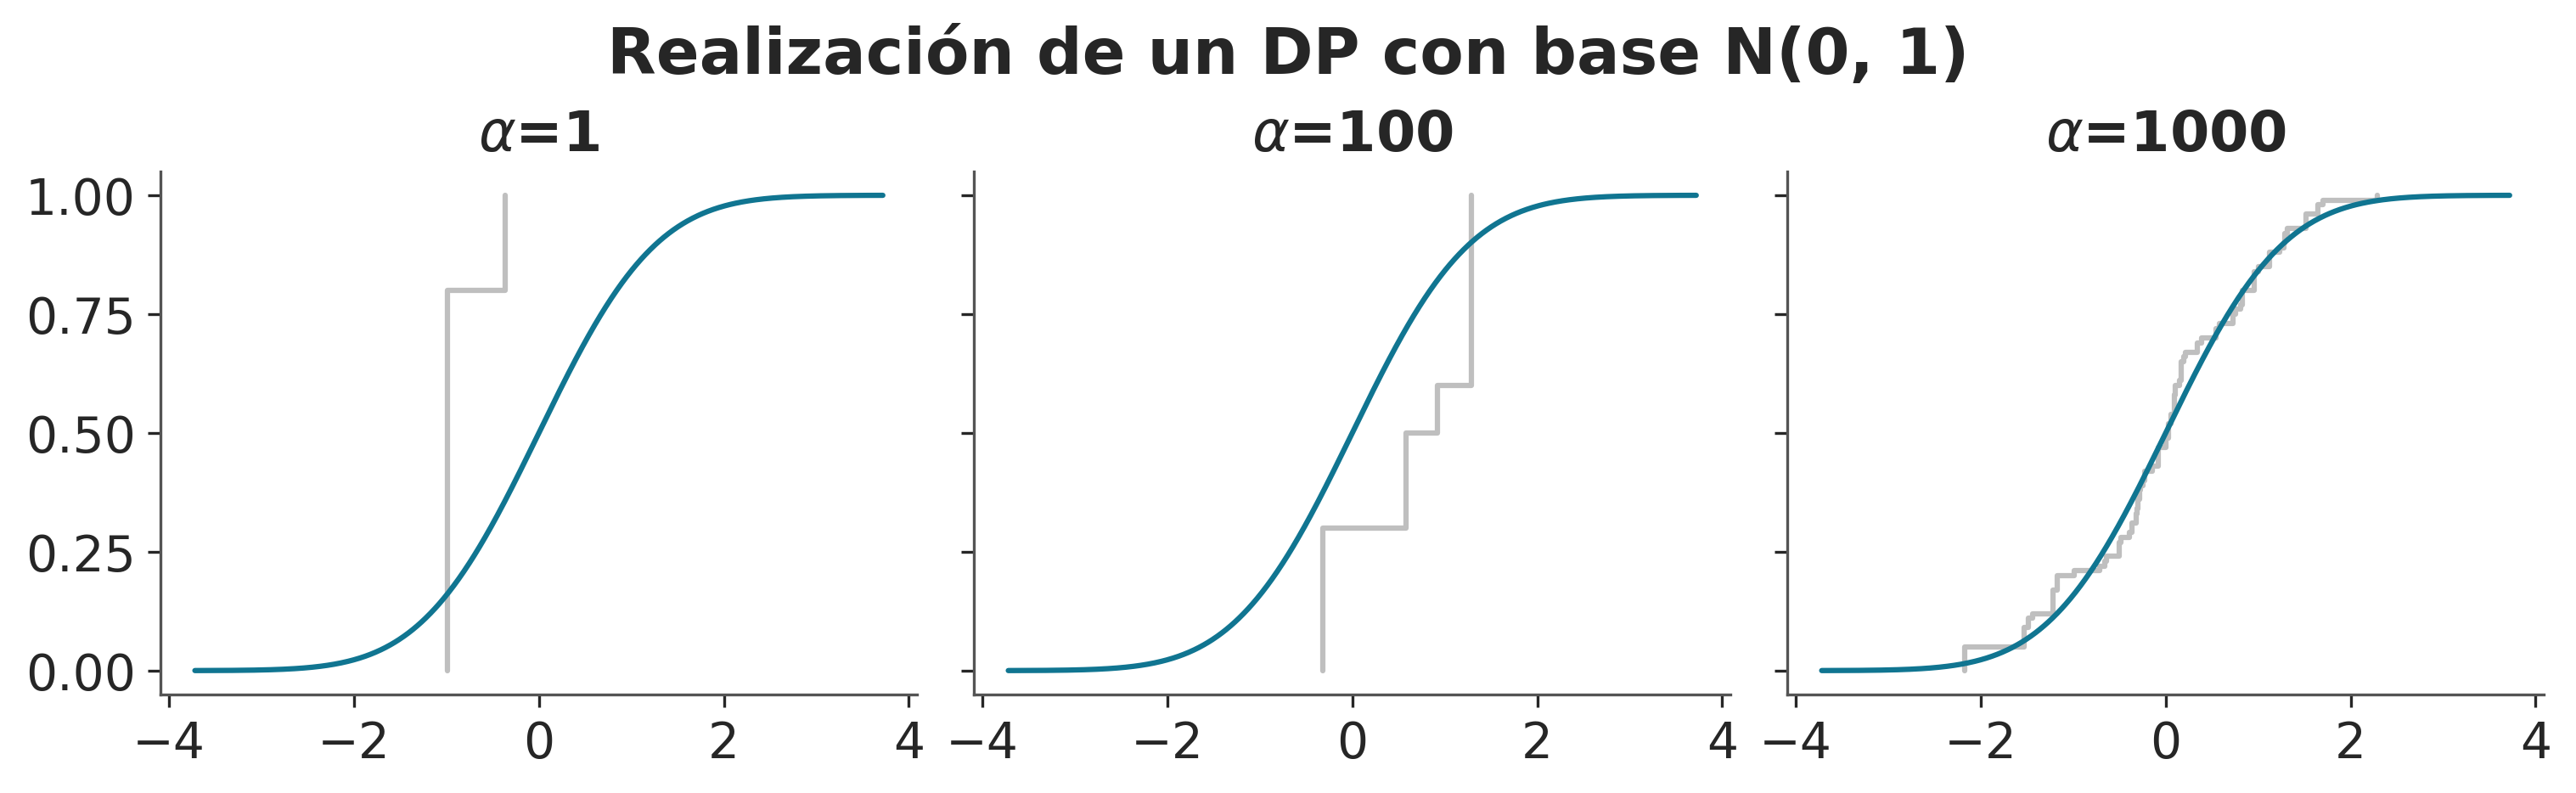

In [31]:
N = 1
base_distribution = pz.Normal(0, 1)

_, axes = plt.subplots(1,3, figsize=(10, 3), sharey=True)

for alpha, ax in zip([1, 100, 1000], axes.ravel()):
    for _ in range(N):
        sample = stick_breaking_process(alpha, base_distribution, 123)
        ax.ecdf(sample, color="0.5", alpha=0.5)
        
    base_distribution.plot_cdf(legend=False, ax=ax)
    ax.set_title(fr"$\alpha$={alpha}")
    
plt.suptitle('Realización de un DP con base N(0, 1)');

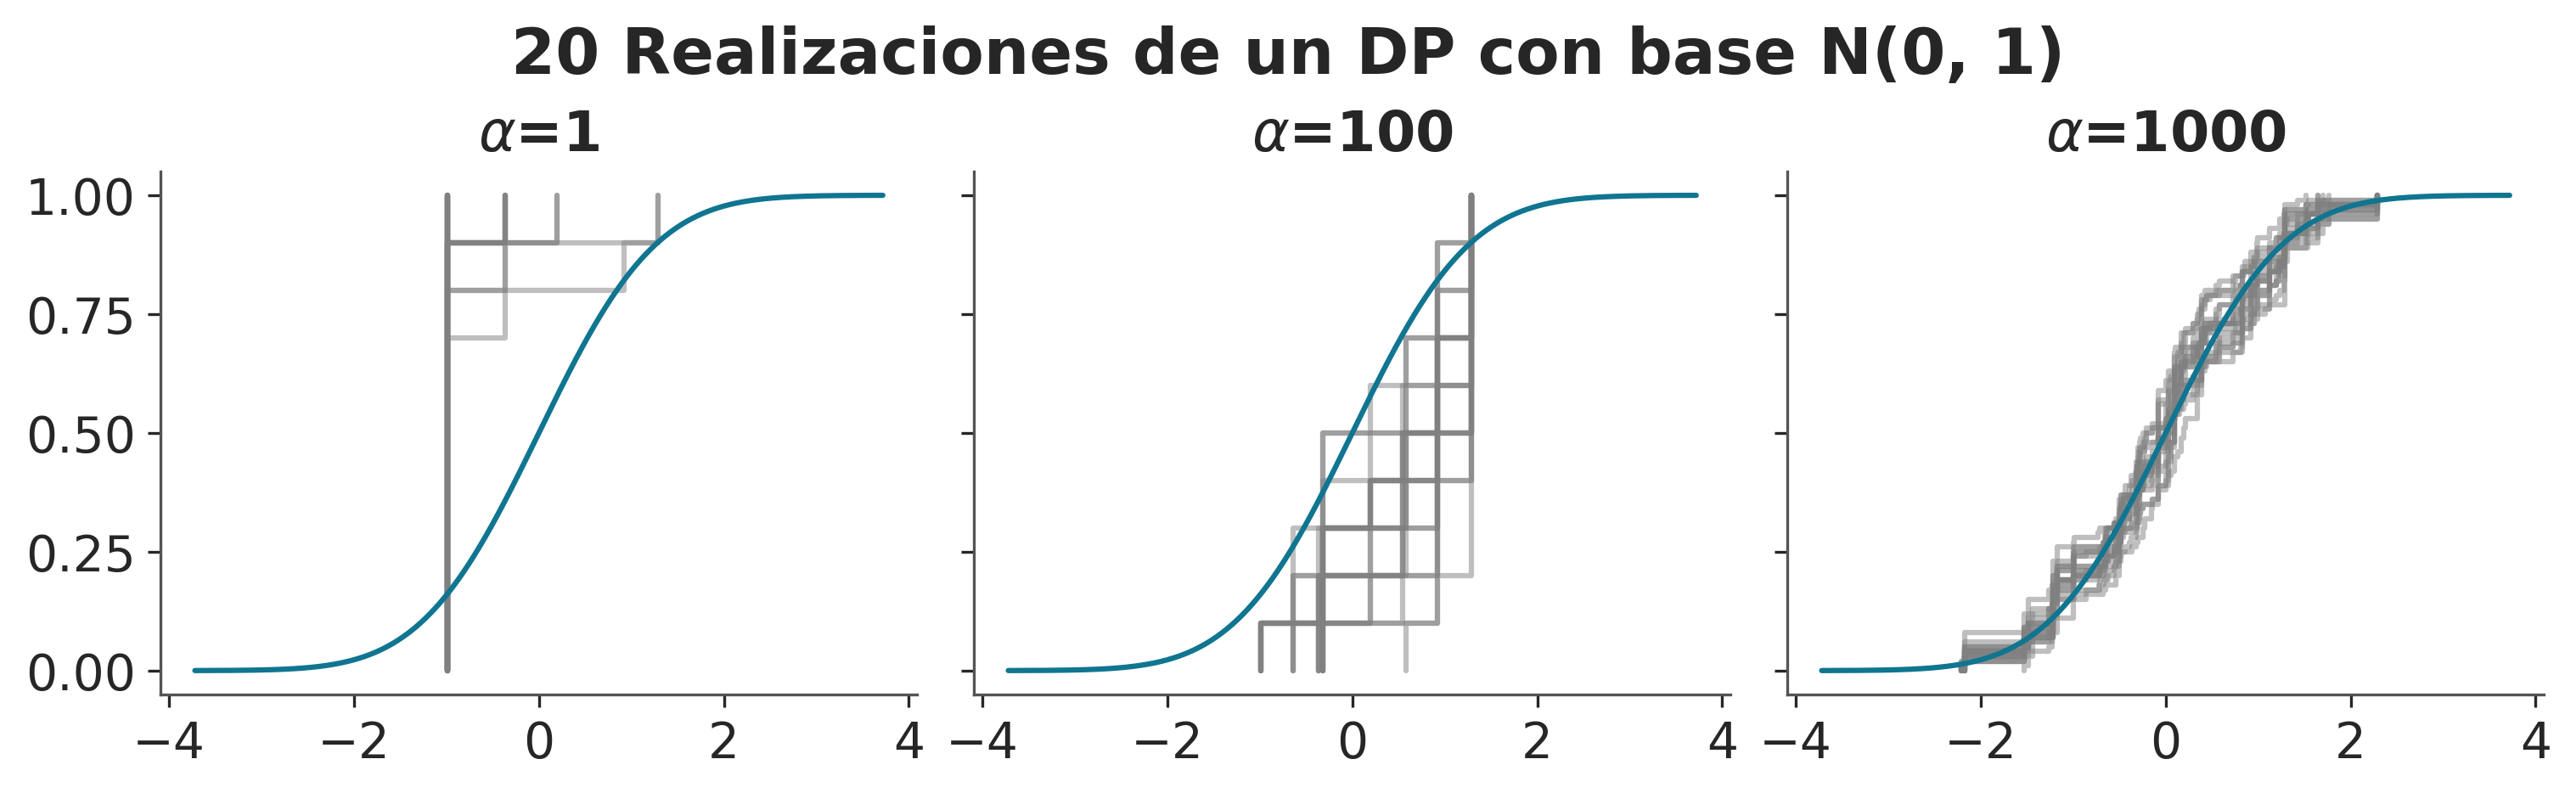

In [32]:
N = 20
base_distribution = pz.Normal(0, 1)

_, axes = plt.subplots(1,3, figsize=(10, 3), sharey=True)

for alpha, ax in zip([1, 100, 1000], axes.ravel()):
    for _ in range(N):
        sample = stick_breaking_process(alpha, base_distribution, 123)
        ax.ecdf(sample, color="0.5", alpha=0.5)
        
    pz.Normal(0, 1).plot_cdf(legend=False, ax=ax)
    ax.set_title(fr"$\alpha$={alpha}")
    
plt.suptitle(f'{N} Realizaciones de un DP con base N(0, 1)');

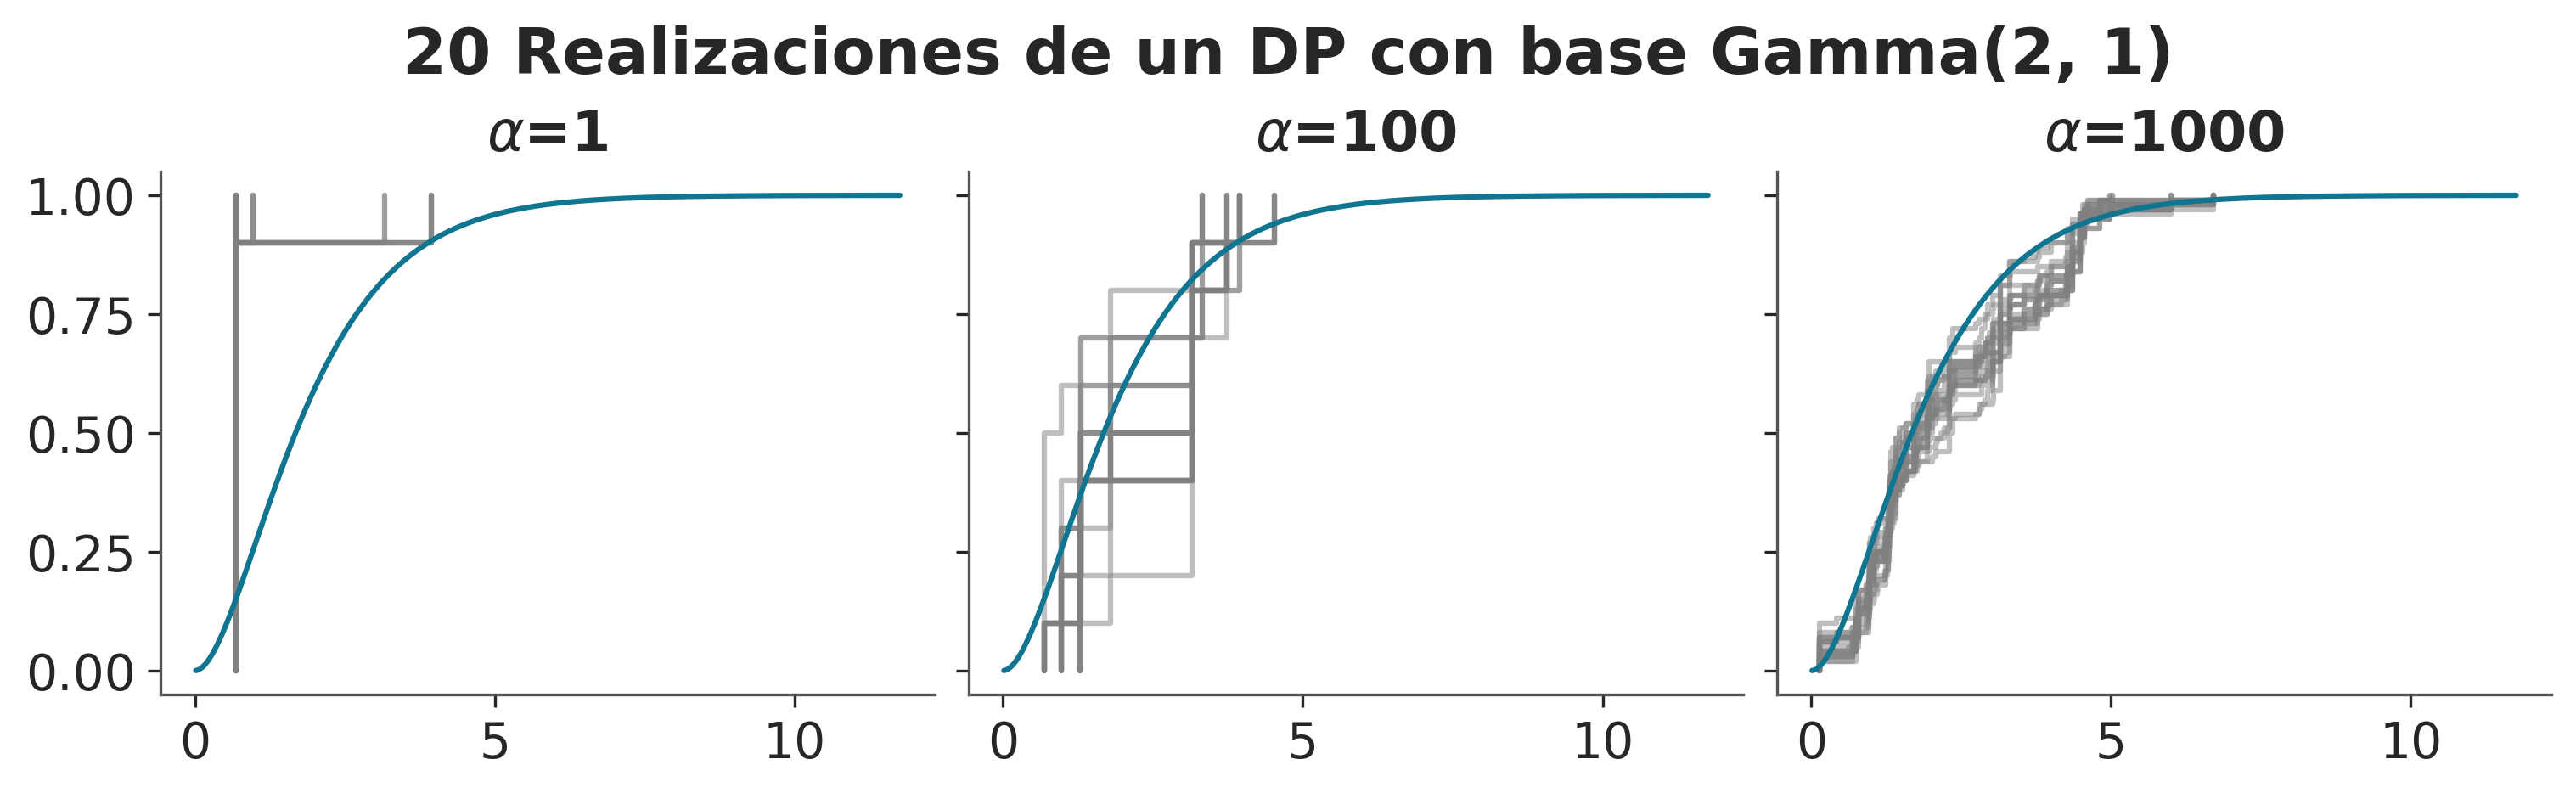

In [33]:
N = 20
base_distribution = pz.Gamma(2, 1)

_, axes = plt.subplots(1,3, figsize=(10, 3), sharey=True)

for alpha, ax in zip([1, 100, 1000], axes.ravel()):
    for _ in range(N):
        sample = stick_breaking_process(alpha, base_distribution, 123)
        ax.ecdf(sample, color="0.5", alpha=0.5)
        
    base_distribution.plot_cdf(legend=False, ax=ax)
    ax.set_title(fr"$\alpha$={alpha}")
    
plt.suptitle(f'{N} Realizaciones de un DP con base Gamma(2, 1)');

### Stick-breaking process II



\begin{align}
\beta_i & \sim \text{Beta}(1, \alpha) \\
w_i & = \beta_i \prod_{j=1}^{i-1} (1 - \beta_j)
\end{align}

$$
\theta_i \sim H 
$$

$H$ es la distribución base del DP.

### Stick-breaking process III

Dados estos elementos podemos definir a un proceso de Dirichlet $G \sim DP(\alpha, H)$ como una suma pesada de masas puntuales localizadas según la distribución base.

$$
G = \sum_{i=1}^{\infty} w_i \delta_{\theta_i}
$$

donde $\delta_{\theta_i}$ es la función delta de Dirac centrada en $\theta_i$.

In [34]:
K = 10

with pm.Model() as model_DP:
    α = pm.Gamma('α', 2, 1)

    w = pm.StickBreakingWeights("w", α, K-1)
    means = pm.Normal('means',
                      mu=np.quantile(cs_exp, np.linspace(0.1, 0.9, K)),
                      sigma=5, shape=K,
                      transform=pm.distributions.transforms.ordered,
                     )
    
    sd = pm.HalfNormal('sd', sigma=5, shape=K)
    obs = pm.NormalMixture('obs', w, means, sigma=sd, observed=cs_exp.values)
    idata = pm.sample(random_seed=123, target_accept=0.9, nuts_sampler="nutpie")

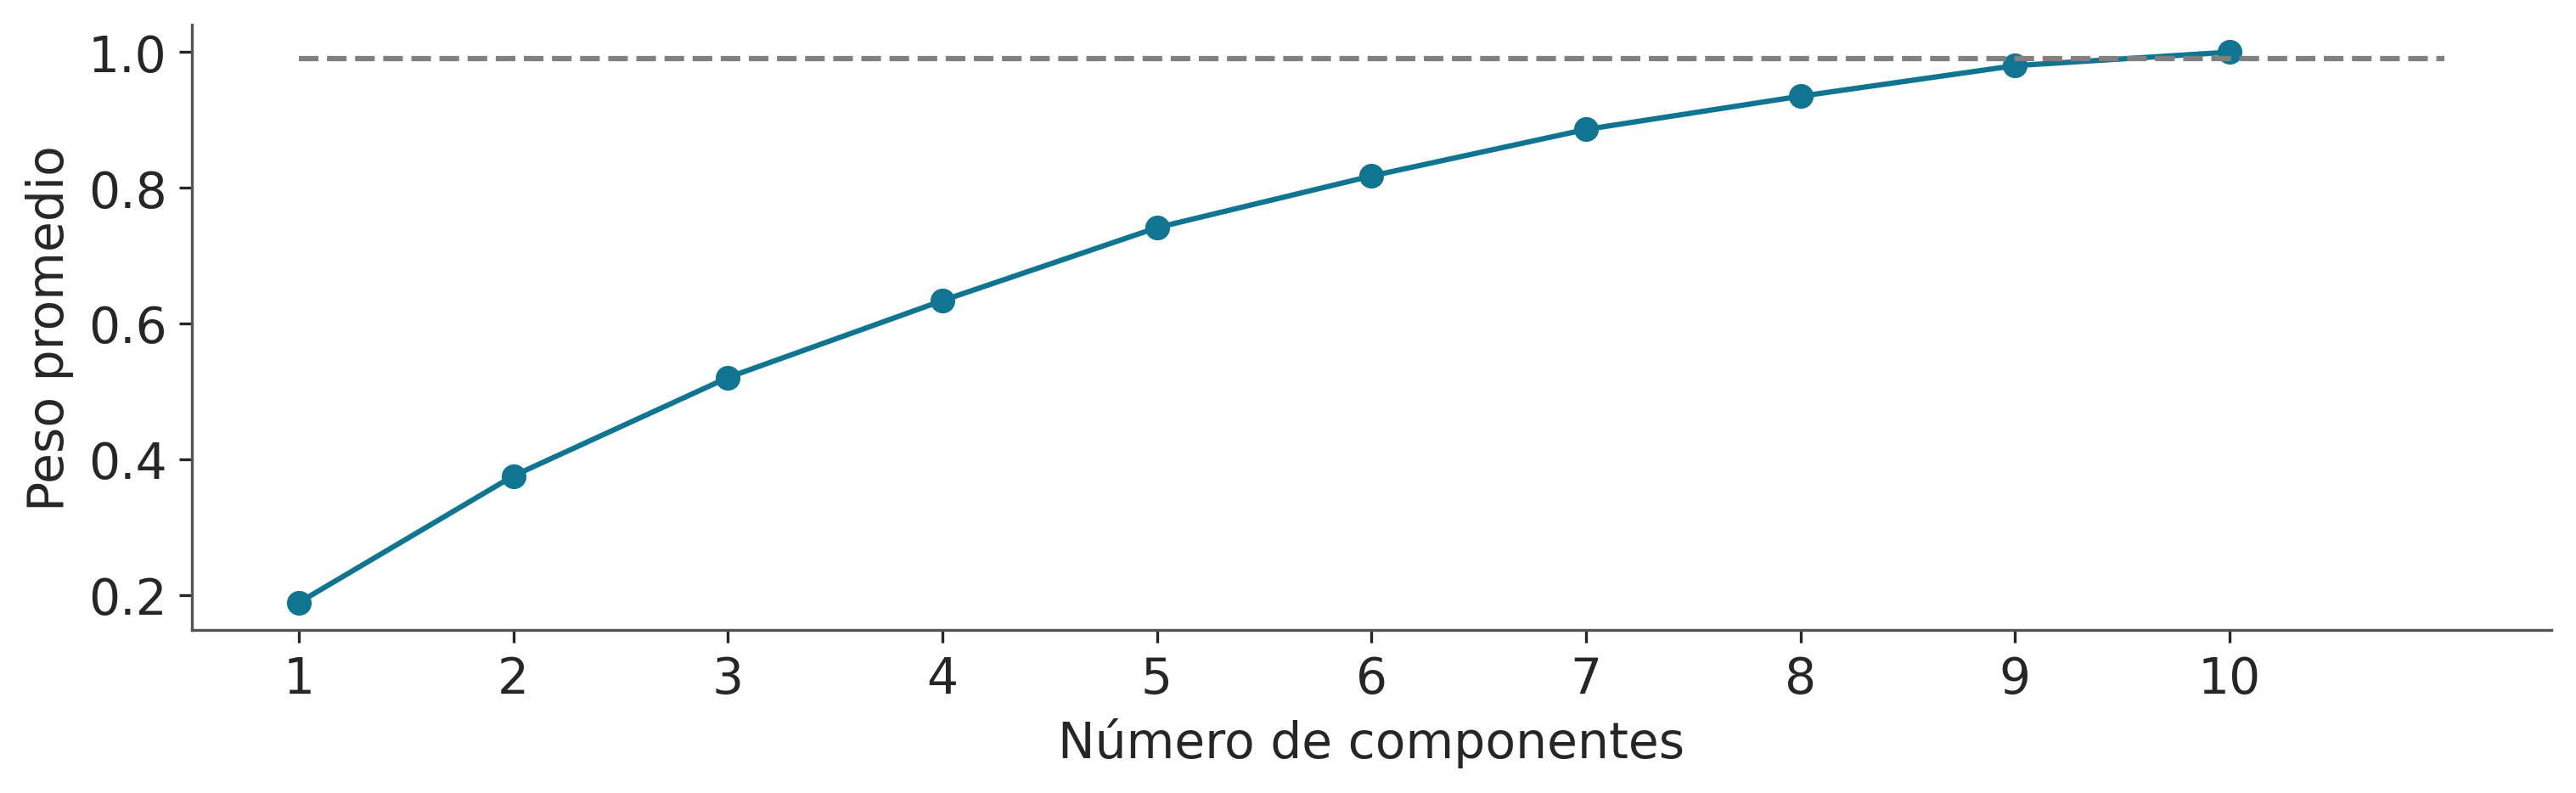

In [35]:
_, ax = plt.subplots(figsize=(10, 3))
plot_w = np.arange(K)
ax.plot(np.cumsum(np.sort(idata.posterior['w'].mean(("chain", "draw")))[::-1]), 'o-')
ax.hlines(0.99, 0, K, ls="--", color="0.5")
ax.set_xticks(plot_w, plot_w+1)
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Peso promedio');

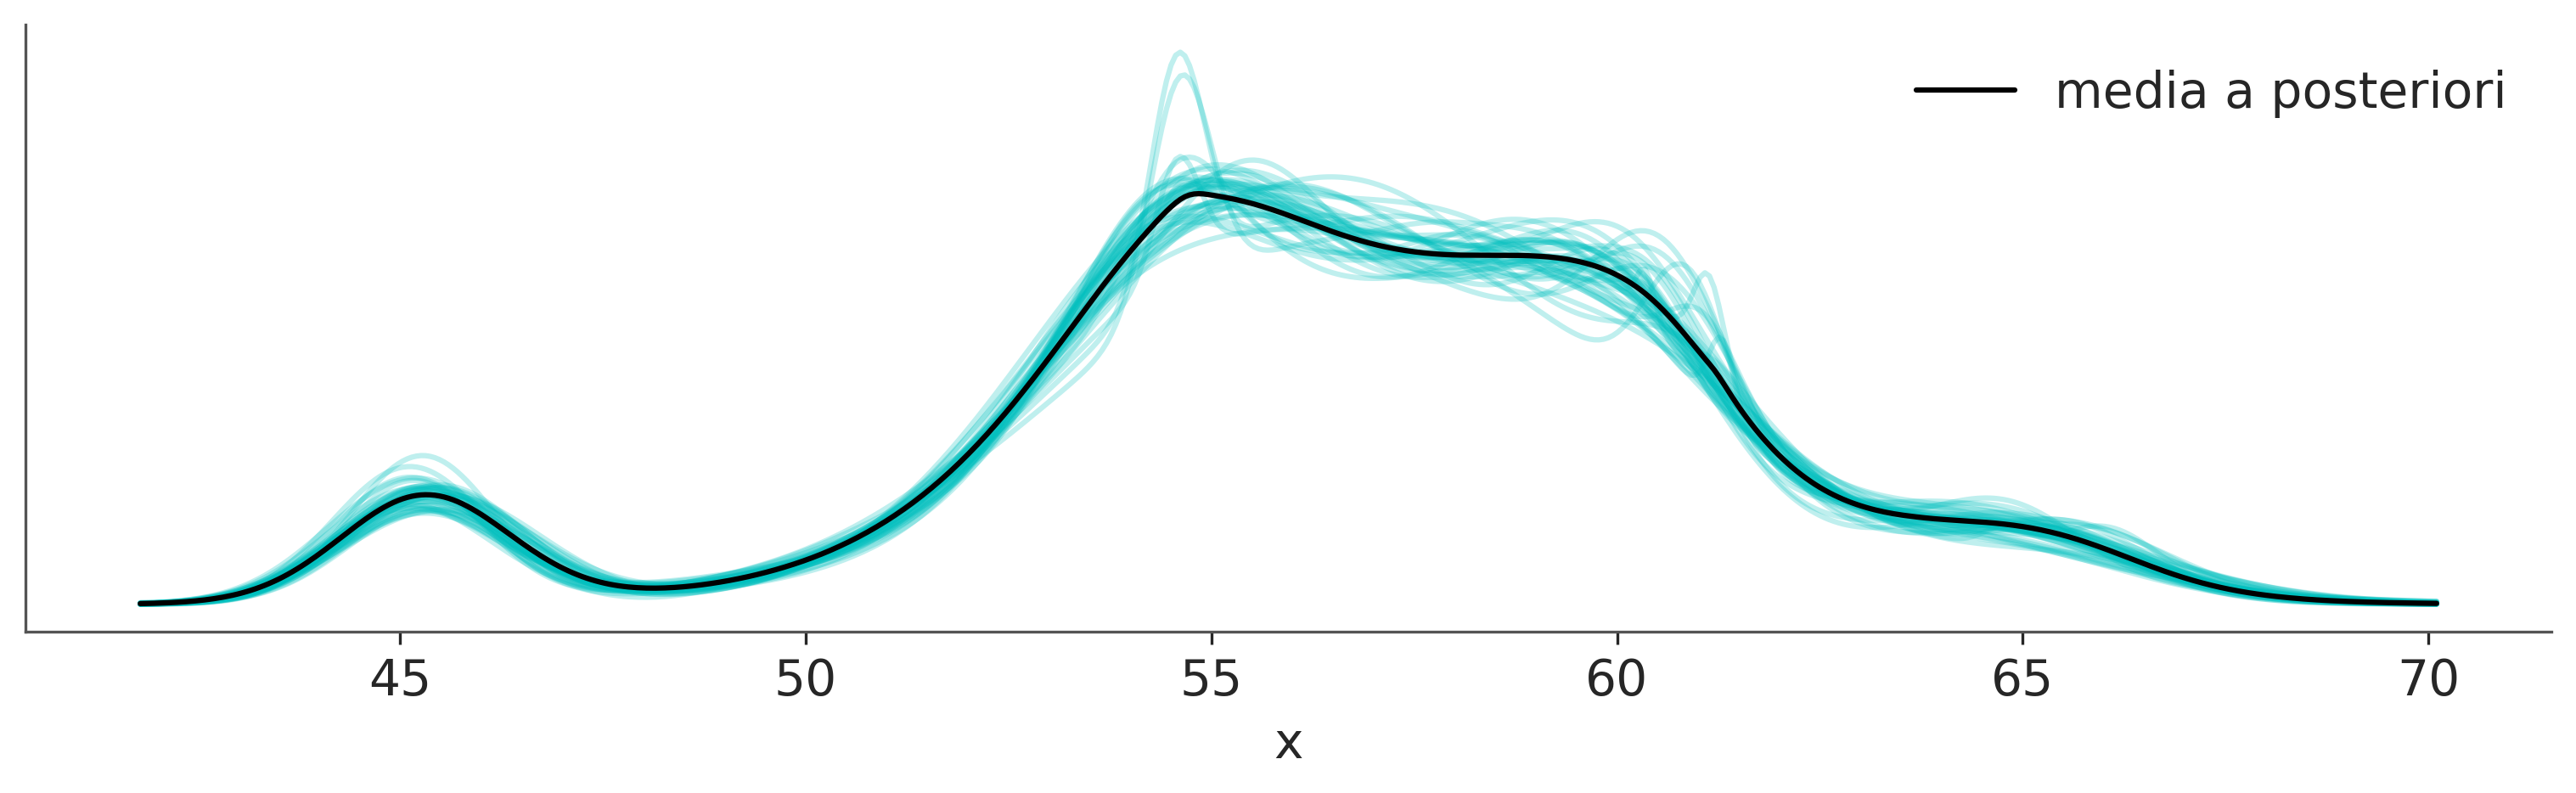

In [36]:
x_plot = np.linspace(cs_exp.min()-1, cs_exp.max()+1, 500)

posterior = idata.posterior.stack(samples=("chain", "draw"))

post_pdf_contribs = pz.Normal(posterior['means'].values[:, None, :],
                              posterior['sd'].values[:, None, :]).pdf(np.atleast_3d(x_plot))

post_pdfs = (posterior['w'].values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=0)


_, ax = plt.subplots(figsize=(10, 3))

ax.plot(x_plot, post_pdfs[:,::100], c='C1', alpha=0.25)
ax.plot(x_plot, post_pdfs.mean(axis=1), c='k', label="media a posteriori")

ax.set_xlabel('x')
ax.set_yticks([])
ax.legend();